In [1]:
# Characterizing Link Channel Impulse Response on POWDER

# Authors (alphabetical order):
# - Cassie Jeng
# - Neal Patwari
# - Aarti Singh
# - Jie Wang
# - Meles Gebreyesus Weldegebriel

# February 2025, Version 0.2

# This python notebook provides code to generate an IQ file with PN codes that can be transmitted between 
# nodes on POWDER using the Shout framework and shows the channel impulse response and multipath resulting 
# from cross-correlating the filtered received signal with the original PN code packet.

In [2]:
# Standard packages
import argparse
import sys
import os
import subprocess
import json
import datetime

# IQ Generation packages
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import lfilter

# PN Generation packages
# !pip install pylfsr
import pylfsr
from pylfsr import LFSR

# Other packages
import itertools
import scipy.io as sio
from scipy import signal, stats
from scipy.signal import find_peaks
import h5py
from matplotlib import rc
rc('xtick',labelsize=14)
rc('ytick',labelsize=14)

In [3]:
# 1. Create an IQ file from PN codes

# IQ Generation functions

# PURPOSE: Create QPSK bits for transmit
# INPUT: inphase and quadrature bits
# OUTPUT: QPSK_bits to transmit
def Information_Transmit_r(inphase, quad):
    in_phase = np.asarray(inphase)
    quadrature = np.asarray(quad)
    QPSK_bits = np.vstack([in_phase, quadrature])
    return QPSK_bits

# PURPOSE: List allowed PN taps based on specified number of stages
# INPUT: N_stages between 7 and 11
# OUTPUT: L_codelen PN code length, ptaps allowed taps
def choose_taps(N_stages):
    L_codelen = (2 ** N_stages) - 1
    if N_stages == 7:
        ptaps = '[7,6] [7,3] [7,1]'
    elif N_stages == 8:
        ptaps = '[8,6,5,4] [8,6,5,3]'
    elif N_stages == 9:
        ptaps = '[9,5] [9,6,4,3]'
    elif N_stages == 10:
        ptaps = '[10,7] [10,3]'
    elif N_stages == 11:
        ptaps = '[11,9] [11,8,5,2]'
    elif N_stages == 12:
        ptaps = '[12,6,4,1]'
    elif N_stages == 13:
        ptaps = '[13,4,3,1]'
    elif N_stages == 14:
        ptaps = '[14,5,3,1]'
    else:
        ptaps = ''
    return L_codelen, ptaps

# PURPOSE: Convert input data to signal space values
# INPUT: data bits, inputVec, outputVec coding
# OUTPUT: output values from outputVec
def lut(data, inputVec, outputVec):
    if len(inputVec) != len(outputVec):
        print('ERROR in function lut: Input and Output vectors must have identical length')
        exit()
    output = np.zeros(data.shape)
    eps = np.finfo('float').eps
    for i in range(len(inputVec)):
        # Find the indices where data is equal to that input value
        for k in range(len(data)):
            if abs(data[k]-inputVec[i]) < eps:
                # Set those indices in the output to be the appropriate output value.
                output[k] = outputVec[i]
    return output

# PURPOSE: Insert 0's between samples to oversample at OS_Rate
# INPUT: x data to oversample, OS_Rate rate to sample
# OUTPUT: x_s oversampled data
def oversample(x, OS_Rate):
    length = len(x[0])
    x_s = np.zeros((1,length*OS_Rate))
    # Fill in one out of every OS_Rate samples with the input values
    count = 0
    h = 0
    for k in range(len(x_s[0])):
        count = count + 1
        if count == OS_Rate:
            x_s[0][k] = x[0][h]
            count = 0
            h = h + 1
    return x_s

# PURPOSE: Create a Square Root Raised Cosine pulse shape
# INPUT: alpha, N, Lp
# OUTPUT: pulse shape for SRRC
def SRRC(alpha, N, Lp):
    # Add epsilon to the n values to avoid numerical problems
    ntemp = list(range(-N*Lp, N*Lp+1))
    n = []
    for each in ntemp:
        n.append(each + math.pow(10,-9))
    # Plug into time domain formula for the SRRC pulse shape
    h = []
    coeff = 1/math.sqrt(N)
    for each in n:
        sine_term = math.sin(math.pi * each * (1-alpha) / N)
        cosine_term = math.cos(math.pi * each * (1+alpha) / N)
        cosine_coeff = 4 * alpha * each / N
        numerator = sine_term + (cosine_coeff * cosine_term)
        denom_coeff = math.pi * each / N
        denom_part = 1 - math.pow(cosine_coeff, 2)
        denominator = denom_coeff * denom_part
        pulse = coeff * numerator / denominator
        h.append(pulse)
    return h

# PURPOSE: Open filename and write array to it as binary
# INPUT: data to write as binary, filename to write to
# OUTPUT: file with complex binary data
def write_complex_binary(data, filename):
    # Open filename and write array to it as binary, format is interleaved float IQ
    re = np.real(data)
    im = np.imag(data)
    binary = np.zeros(len(data)*2, dtype=np.float32)
    binary[::2] = re
    binary[1::2] = im
    binary.tofile(filename)

# PURPOSE: Load samples from binary file
# INPUT: filename to load complex binary from
# OUTPUT: samps from file
def get_samps_from_file(filename):
    # File should be in GNURadio's format, i.e., interleaved I/Q samples as float32
    samples = np.fromfile(filename, dtype= np.float32)
    samps = (samples[::2] + 1j*samples[1::2]).astype((np.complex64)) # convert to IQIQIQ
    return samps

# PN code generation

samples_per_chip = 2
samp_rate = 56000000.0
#samp_rate = 250000.0
alpha = 0.75
A = math.sqrt(9/2)
Lp = 6

N_stages = 14
L_codelen, ptaps = choose_taps(N_stages)
print('Code length L = ' + str(L_codelen))
print('Valid taps to choose: ' + ptaps)

# PN code generation

# In-Phase Sequence
state = '0,0,0,0,0,0,0,0,0,0,0,1,0,0'
taps = '14,5,3,1'

state = state.split(',')
state = [int(s) for s in state]

taps = taps.split(',')
taps = [int(t) for t in taps]

L = LFSR(initstate=state, fpoly=taps)
pn_iSeq = L.getFullPeriod()

# Quadrature Sequence
state = '0,0,0,0,0,0,0,0,1,0,0,0,0,0'
taps = '14,5,3,1'

state = state.split(',')
state = [int(s) for s in state]

taps = taps.split(',')
taps = [int(t) for t in taps]

L = LFSR(initstate=state, fpoly=taps)
pn_qSeq = L.getFullPeriod()

Frame = Information_Transmit_r(pn_iSeq, pn_qSeq)

# Modulation
# INPUT: data
# OUTPUT: modulated values, x
xI_list = []
for each in Frame[0]:
    if each == 0:
        xI_list.append(-1)
    else:
        xI_list.append(1)

xQ_list = []
for each in Frame[1]:
    if each == 0:
        xQ_list.append(-1) # -1j
    else:
        xQ_list.append(1) # 1j
xI_list_new = [i * A for i in xI_list]
xQ_list_new = [i * A for i in xQ_list]

xI = np.array(xI_list_new)
xQ = np.array(xQ_list_new)

xI = xI.reshape((1,len(Frame[0])))
xQ = xQ.reshape((1,len(Frame[1])))

# Oversample
# INPUT: modulated values, x
# OUTPUT: modulated values at sampling rate, samples_per_chip
x_s_I = oversample(xI,samples_per_chip)
x_s_Q = oversample(xQ,samples_per_chip)

pulse = SRRC(alpha,samples_per_chip,Lp)
pulse = np.array(pulse)
pulse = np.reshape(pulse,pulse.size)

x_s_I = np.reshape(x_s_I, x_s_I.size)
x_s_Q = np.reshape(x_s_Q, x_s_Q.size)
s_0_I = np.convolve(x_s_I, pulse, mode='full')
s_0_Q = np.convolve(x_s_Q, pulse, mode='full')

QPSK_samples = s_0_I

# Transmit 3 copies of PN code packet
numPN = 3
P = len(pulse)-1
P2 = int(P/2)
oversample_PNlen = samples_per_chip*L_codelen
QPSK_samples_add = np.zeros((oversample_PNlen*numPN)+P, dtype=type(QPSK_samples[0]))

for i in range(numPN):
    QPSK_samples_add[i*oversample_PNlen:(i*oversample_PNlen)+oversample_PNlen+P] += QPSK_samples

QPSK_samples_Final = np.hstack([np.zeros(1024, dtype=type(QPSK_samples[0])),QPSK_samples_add])

Code length L = 16383
Valid taps to choose: [14,5,3,1]


In [4]:
# 3. Cross-Correlation and Channel Impulse Response from Collected Data

# Reading data functions

# PURPOSE: Get data and time from timestamp
# INPUT: timestamp
# OUTPUT: data and time, example: 01-04-2023, 19:50:27
def get_time_string(timestamp):
    date_time = datetime.datetime.fromtimestamp(int(timestamp))
    return date_time.strftime("%m-%d-%Y, %H:%M:%S")

# PURPOSE: Load parameters from the saved json file
# INPUT: data folder, saved json_file
# OUTPUT: experiment specifications from json file
def JsonLoad(folder, json_file):
    config_file = folder+'/'+json_file
    config_dict = json.load(open(config_file))[0]
    nsamps = config_dict['nsamps']
    rxrate = config_dict['rxrate']
    rxfreq = config_dict['rxfreq']
    wotxrepeat = config_dict['wotxrepeat']
    rxrepeat = config_dict['rxrepeat']
    txnodes = config_dict['txclients']
    rxnodes = config_dict['rxclients']
    return rxrepeat, rxrate, txnodes, rxnodes

# PURPOSE: Load data from hdf5 format measurement file
# INPUT: meas_folder path to measurement folder
# OUTPUT: data, noise, and txrxloc node names
def traverse_dataset(meas_folder):
    data = {}
    noise = {}
    txrxloc = {}

    dataset = h5py.File(meas_folder + '/measurements.hdf5', "r")
    for cmd in dataset.keys():
        if cmd == 'saveiq':
            cmd_time = list(dataset[cmd].keys())[0]
            # ----- Uncomment to see time stamps
            # print('Time Collected:', get_time_string(cmd_time))
            # print('Command meta data:', list(dataset[cmd][cmd_time].attrs.items()))
        elif cmd == 'saveiq_w_tx':
            cmd_time = list(dataset[cmd].keys())[0]
            # ----- Uncomment to see time stamps
            # print('Time Collected:', get_time_string(cmd_time))
            # print('Command meta data:', list(dataset[cmd][cmd_time].attrs.items()))
            for tx in dataset[cmd][cmd_time].keys():
                if tx == 'wo_tx':
                    for rx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx in dataset[cmd][cmd_time][tx][rx_gain].keys():
                            repeat = np.shape(dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'])[0]
                            samplesNotx = dataset[cmd][cmd_time][tx][rx_gain][rx]['rxsamples'][:repeat, :]
                            namelist = rx.split('-')
                            noise[namelist[1]] = samplesNotx
                else:
                    for tx_gain in dataset[cmd][cmd_time][tx].keys():
                        for rx_gain in dataset[cmd][cmd_time][tx][tx_gain].keys():
                            for rx in dataset[cmd][cmd_time][tx][tx_gain][rx_gain].keys():
                                repeat = np.shape(dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'])[0]
                                txrxloc.setdefault(tx, []).extend([rx]*repeat)
                                rxsamples = dataset[cmd][cmd_time][tx][tx_gain][rx_gain][rx]['rxsamples'][:repeat, :]
                                data.setdefault(tx, []).append(np.array(rxsamples))
        else:
            print('Unsupported command: ', cmd)
    return data, noise, txrxloc

In [5]:
# Access JSON information

folder = 'Dense-Deployment_Shout_meas_02-18-2025_11-38-19'

jsonfile = 'save_iq_w_tx_file.json'
rxrepeat, samp_rate, txlocs, rxlocs = JsonLoad(folder, jsonfile)
print('txlocs:')
print(txlocs)
print('\nrxlocs:')
print(rxlocs)

# Load data from the HDF5 file, save IQ sample arrays
rx_data, _, txrxloc = traverse_dataset(folder)

rx_names = []
for rxl in rxlocs:
    rx_names.append(rxl.split('-')[1])

rx_names = sorted(rx_names)

tx_names = []
for txl in txlocs:
    tx_names.append(txl.split('-')[1])

tx_names = sorted(tx_names)

txlocs:
['cnode-ebc-dd-b210', 'cnode-mario-dd-b210', 'cnode-ustar-dd-b210', 'cnode-guesthouse-dd-b210', 'cnode-moran-dd-b210']

rxlocs:
['cnode-ebc-dd-b210', 'cnode-mario-dd-b210', 'cnode-ustar-dd-b210', 'cnode-guesthouse-dd-b210', 'cnode-moran-dd-b210']


In [6]:
# CIR functions

# PURPOSE: Cross-correlate received signal with transmitted signal.
#          Highest amplitude corresponds to the index delay where the
#          transmitted packet is found in the received packet.
# INPUT: rx0 received signal, packetSignal transmitted PN code packet
# OUTPUT: lagIndex highest correlation delay index, lags, xcorr_mag, peak
def crossCorrelationMax(rx0, packetSignal):
    # Cross correlate with the original packet to find it in the noisy signal
    lags = signal.correlation_lags(len(rx0), len(packetSignal), mode='same')
    xcorr_out = signal.correlate(rx0, packetSignal, mode='same')
    xcorr_mag = np.abs(xcorr_out)

    length_of_packet = len(packetSignal)
    maxIndex = np.argmax(xcorr_mag[:len(xcorr_mag)-length_of_packet])
    lagIndex = lags[maxIndex]
    peak = lags[np.argmax(xcorr_mag)]

    plt.figure()
    plt.plot(((lags/samp_rate)*1000000), xcorr_mag, label='|X-Correlation|')
    plt.legend(loc='upper right')
    #plt.plot(((peak/samp_rate)*1000000), xcorr_mag[peak], 'xr')
    plt.ylabel('|X-Correlation| (mW)', fontsize=14)
    plt.xlabel(r'Time ($\mu$s)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return lagIndex, lags, xcorr_mag, peak

# PURPOSE: Convert samples to microseconds
# INPUT: value in samples
# OUTPUT: time value in microseconds (us)
def samples_to_us(value, samp_rate):
    return (float)((value/samp_rate)*1000000)

In [7]:
# JSON of RT CIR with correct heights, more allowed reflections, more samples collected (more tx signals sent)
# "tx-rx": [f_rttau, f_rta]
# rt_results_dict = {}
# rt_json = json.loads(json.dumps(rt_results_dict))

# rt_json_filename = 'RTcir_rt_nheight.json'
# rt_json_filename = 'RTcir_rt.json'
# rt_json_filename = 'RTcir_dd.json'
rt_json_filename = 'RTcir_dd_diff.json'

with open(rt_json_filename, 'r') as jsonfile:
    rt_json = json.load(jsonfile)[0]


 ----- PLOTNUM: 0, TX: cnode-ebc-dd-b210, RX: cnode-mario-dd-b210 ----- 



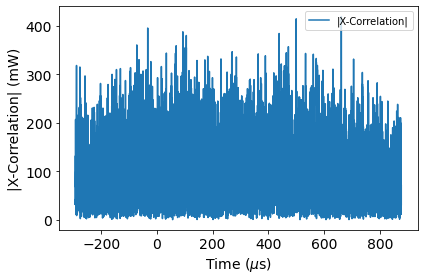

ebc-mario
RX Time Delay: -33.0 us
Unmatched max amplitude Tau (RT): 230.3586 us
Max amplitude measured CIR, with time adjustment: 2719.9773 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.00606497344076689


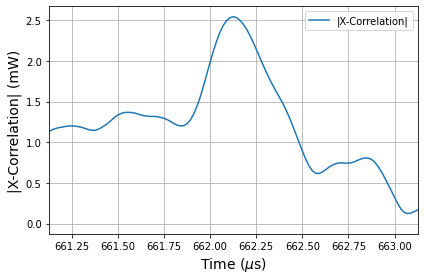

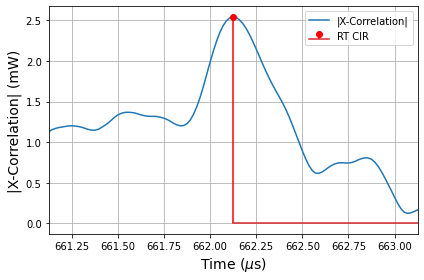

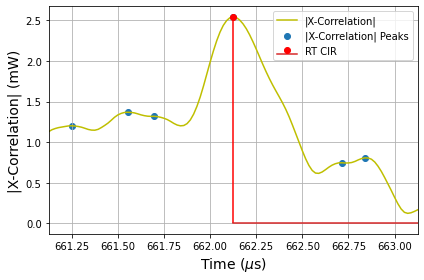

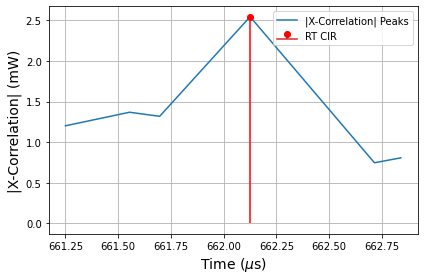

-- Total Received Power --
RT: 6.46 W
CIR (local peaks): 12.72 W
CIR (full): 40646.54 W

-- RMS Delay Spread --
RT: 0.0 us
CIR (local peaks): 0.4111919810828337 us


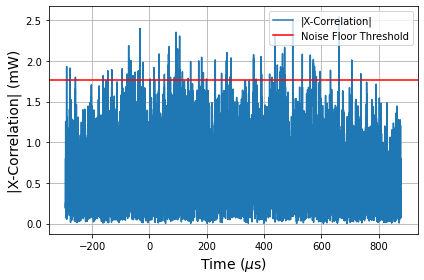

noise_std threshold: 1.7709737089546869
RT CIR at 662.125 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 2.543
Scaled RT CIR amplitude: 2.543

MATCH


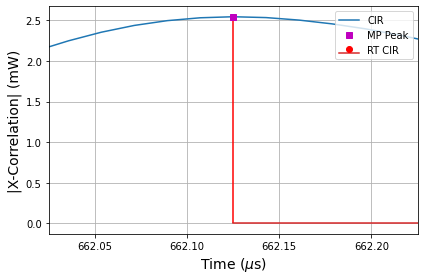

Number of total peaks: 10
Number of Non-matching Peaks: 9
Number of Peaks close in time (ns): 1
Number of Matching Peaks (time and amplitude): 1

0 pre-peak bucket peak matches.
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/9 --> 0.0% match rate

 ----- PLOTNUM: 1, TX: cnode-ebc-dd-b210, RX: cnode-ustar-dd-b210 ----- 



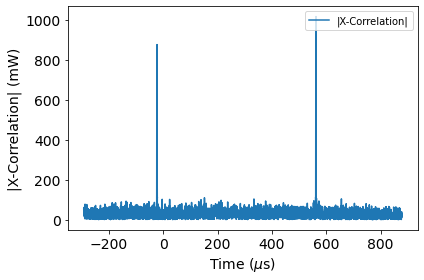

ebc-ustar
RX Time Delay: -22.982142857142858 us
Unmatched max amplitude Tau (RT): 86.685554 us
Max amplitude measured CIR, with time adjustment: 2619.9773 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.03481197113159366


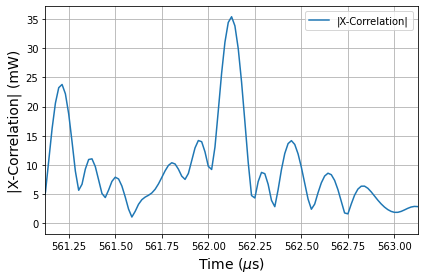

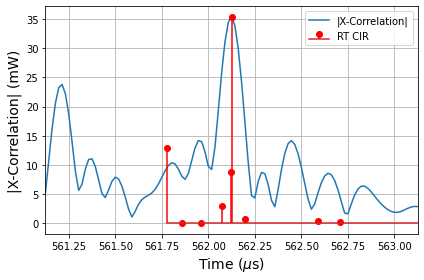

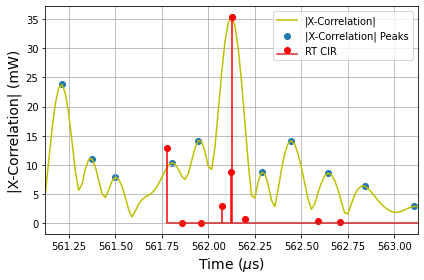

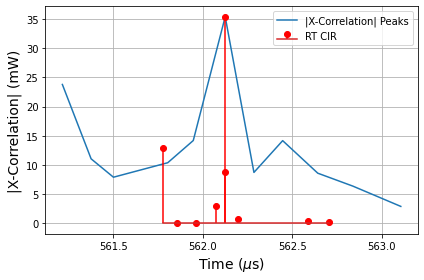

-- Total Received Power --
RT: 1504.74 W
CIR (local peaks): 2712.61 W
CIR (full): 133572.79 W

-- RMS Delay Spread --
RT: 0.1091826581646874 us
CIR (local peaks): 0.44386375268969636 us


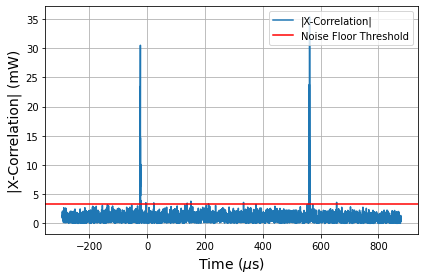

noise_std threshold: 3.29504315982224
RT CIR at 561.776186 microseconds is 27.38542857127868 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.393
Scaled RT CIR amplitude: 12.847

MATCH


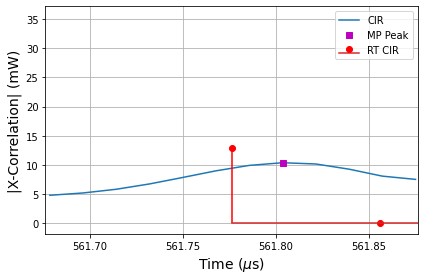

RT CIR at 562.125 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 35.379
Scaled RT CIR amplitude: 35.379

MATCH


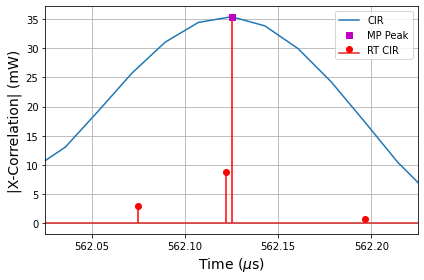

RT CIR at 561.959166 microseconds is 12.73742857142679 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 14.194
Scaled RT CIR amplitude: 0.105


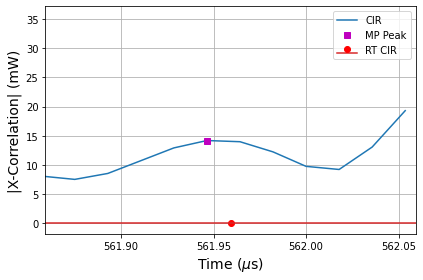

RT CIR at 562.704826 microseconds is 61.96885714291511 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 8.602
Scaled RT CIR amplitude: 0.22


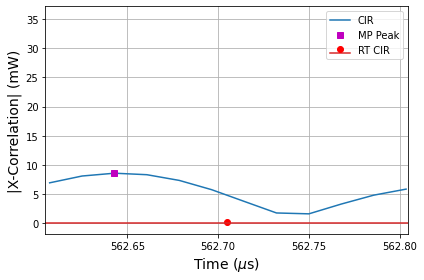

RT CIR at 562.074926 microseconds is 50.07399999999507 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 35.379
Scaled RT CIR amplitude: 3.04


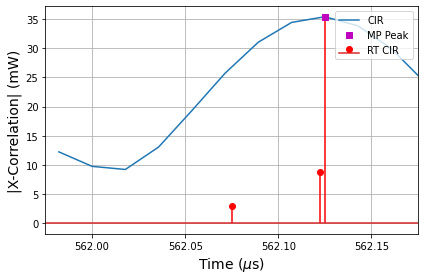

RT CIR at 561.856136 microseconds is 52.56457142866111 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.393
Scaled RT CIR amplitude: 0.04


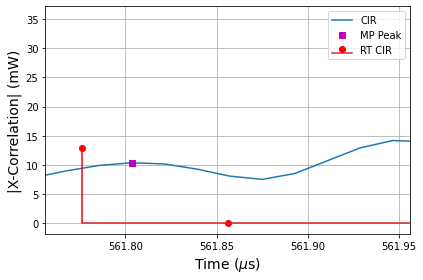

RT CIR at 562.1222319999999 microseconds is 2.7680000000600558 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 35.379
Scaled RT CIR amplitude: 8.824


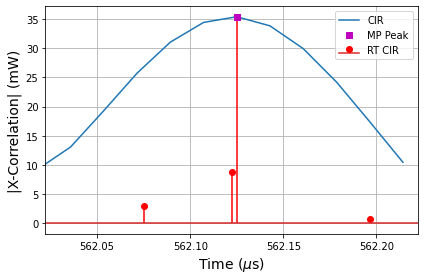

RT CIR at 562.196826 microseconds is 71.82599999998729 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 35.379
Scaled RT CIR amplitude: 0.753


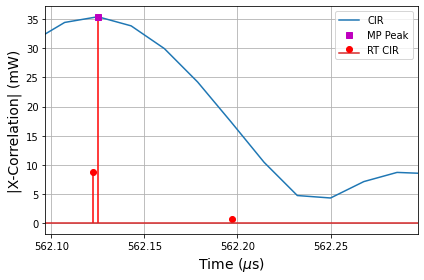

RT CIR at 562.589566 microseconds is 53.29114285711967 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 8.602
Scaled RT CIR amplitude: 0.498


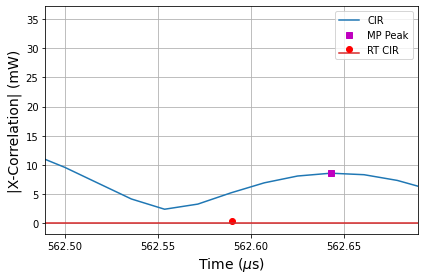

Number of total peaks: 83
Number of Non-matching Peaks: 74
Number of Peaks close in time (ns): 9
Number of Matching Peaks (time and amplitude): 2

Pre-peak bucket matches: 1/3 --> 33.33333333333333% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/4 --> 25.0% match rate
Post-peak bucket matches: 0/76 --> 0.0% match rate

 ----- PLOTNUM: 2, TX: cnode-ebc-dd-b210, RX: cnode-guesthouse-dd-b210 ----- 



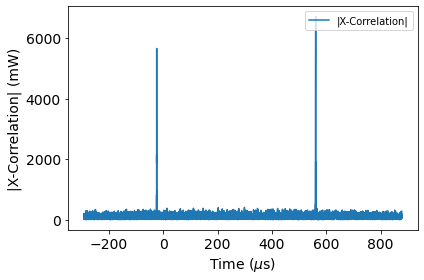

ebc-guesthouse
RX Time Delay: -24.196428571428573 us
Unmatched max amplitude Tau (RT): 59.80318 us
Max amplitude measured CIR, with time adjustment: 2618.7630142857142 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.009094727230496353


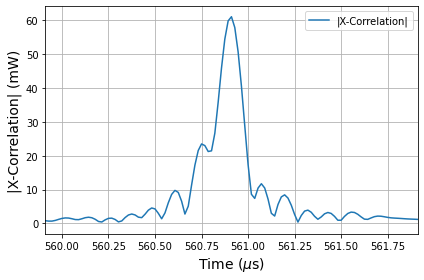

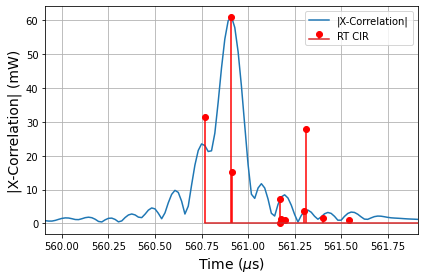

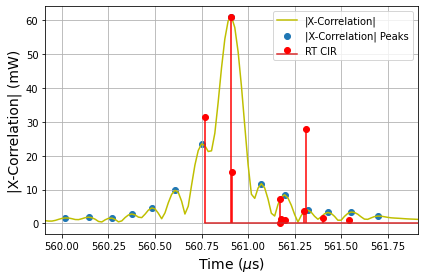

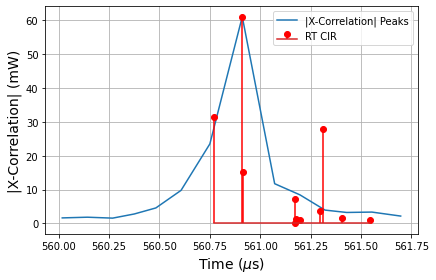

-- Total Received Power --
RT: 5784.39 W
CIR (local peaks): 4663.31 W
CIR (full): 145515.99 W

-- RMS Delay Spread --
RT: 0.15732544864311337 us
CIR (local peaks): 0.10931609167119426 us


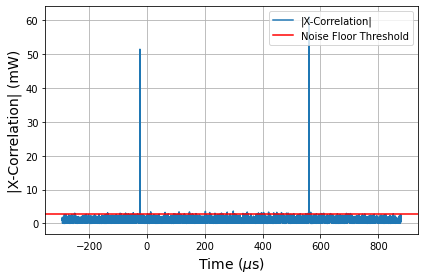

noise_std threshold: 2.7440310445157787
RT CIR at 560.7700442857143 microseconds is 20.044285714334364 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 23.493
Scaled RT CIR amplitude: 31.455

MATCH


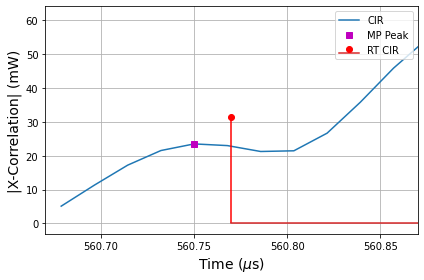

RT CIR at 561.3107642857143 microseconds is 10.664285714256039 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 3.945
Scaled RT CIR amplitude: 27.757


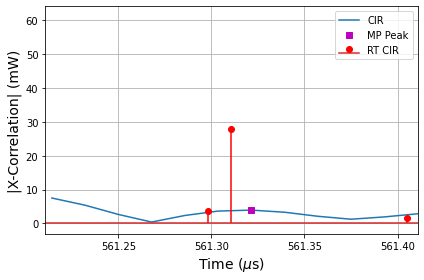

RT CIR at 560.9107142857143 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 61.047
Scaled RT CIR amplitude: 61.047

MATCH


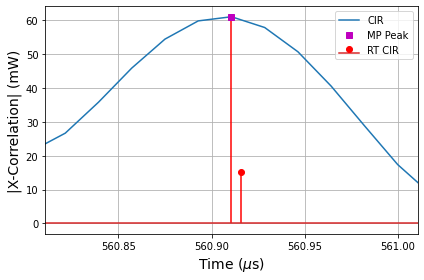

RT CIR at 561.5433212857143 microseconds is 10.250142857103128 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 3.363
Scaled RT CIR amplitude: 0.917


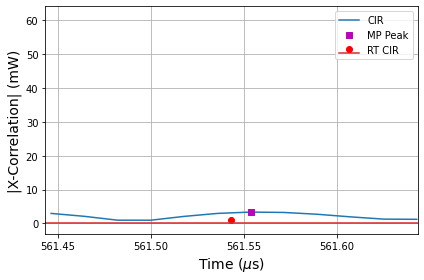

RT CIR at 561.4049242857143 microseconds is 83.49571428573199 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 3.945
Scaled RT CIR amplitude: 1.553


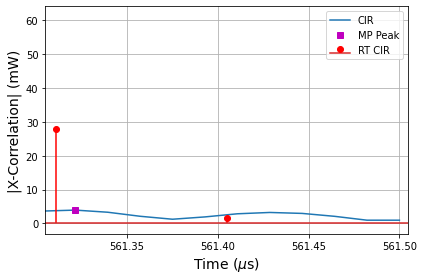

RT CIR at 561.2980812857144 microseconds is 23.347285714180543 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 3.945
Scaled RT CIR amplitude: 3.601

MATCH


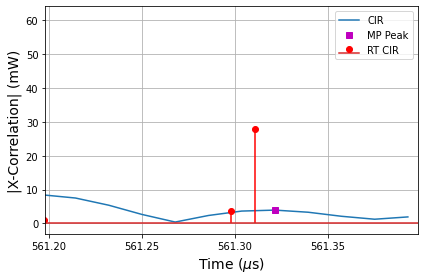

RT CIR at 561.1975482857143 microseconds is 1.1197142857781728 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 8.459
Scaled RT CIR amplitude: 0.952


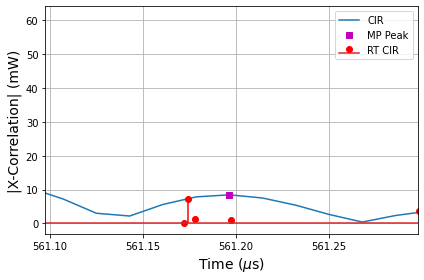

RT CIR at 561.1719342857143 microseconds is 24.494285714240505 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 8.459
Scaled RT CIR amplitude: 0.216


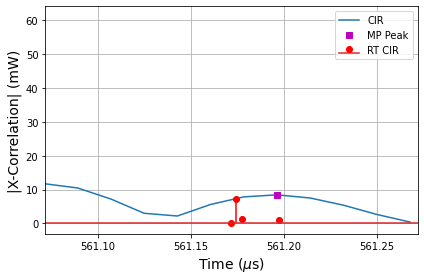

RT CIR at 561.1741542857144 microseconds is 22.274285714161124 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 8.459
Scaled RT CIR amplitude: 7.129

MATCH


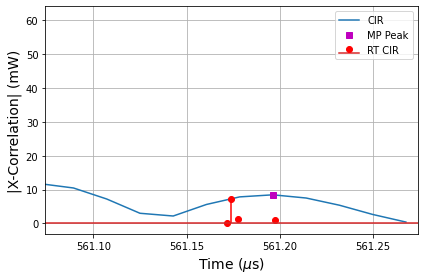

RT CIR at 560.9156442857143 microseconds is 4.929999999944812 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 61.047
Scaled RT CIR amplitude: 15.104


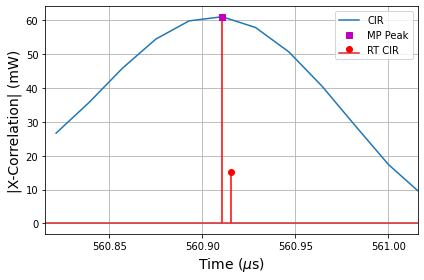

RT CIR at 561.1776982857143 microseconds is 18.73028571424129 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 8.459
Scaled RT CIR amplitude: 1.282


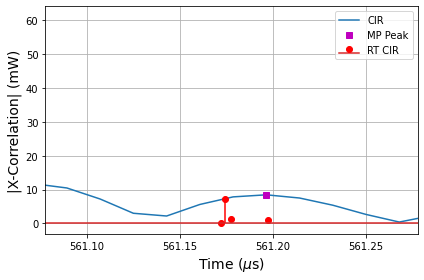

Number of total peaks: 68
Number of Non-matching Peaks: 57
Number of Peaks close in time (ns): 11
Number of Matching Peaks (time and amplitude): 4

Pre-peak bucket matches: 1/1 --> 100.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/2 --> 50.0% match rate
Post-peak bucket matches: 2/65 --> 3.076923076923077% match rate

 ----- PLOTNUM: 3, TX: cnode-ebc-dd-b210, RX: cnode-moran-dd-b210 ----- 



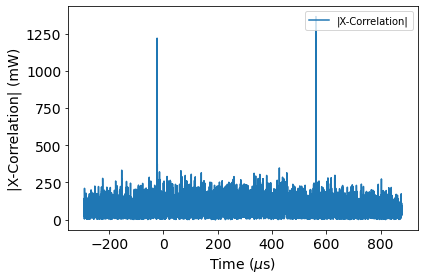

ebc-moran
RX Time Delay: -23.41071428571429 us
Unmatched max amplitude Tau (RT): 107.94108 us
Max amplitude measured CIR, with time adjustment: 2619.4058714285716 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.031019492583003048


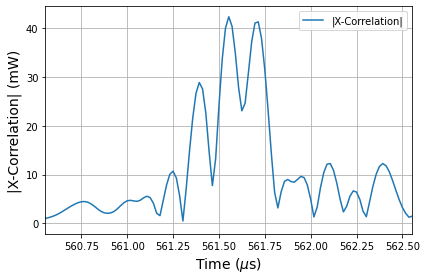

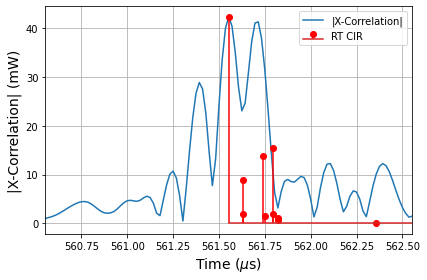

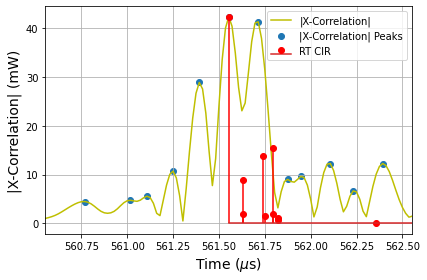

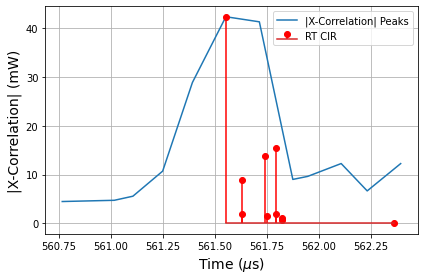

-- Total Received Power --
RT: 2318.53 W
CIR (local peaks): 5044.72 W
CIR (full): 759724.52 W

-- RMS Delay Spread --
RT: 0.08562076117940547 us
CIR (local peaks): 0.23147587203990141 us


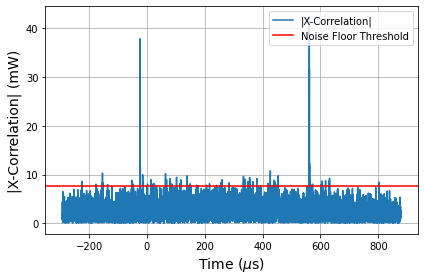

noise_std threshold: 7.596758542007264
RT CIR at 561.5535714285714 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 42.359
Scaled RT CIR amplitude: 42.359

MATCH


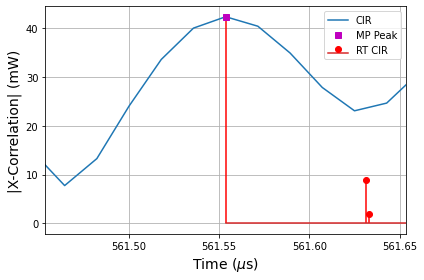

RT CIR at 561.7933814285715 microseconds is 79.0957142858133 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 41.316
Scaled RT CIR amplitude: 15.508


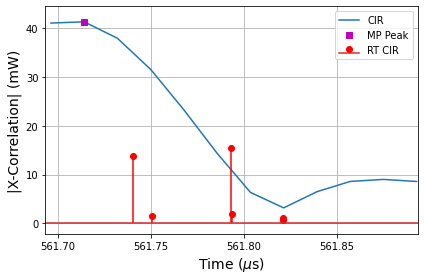

RT CIR at 617.6750114285715 microseconds is 39.274285714213875 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 8.752
Scaled RT CIR amplitude: 0.073


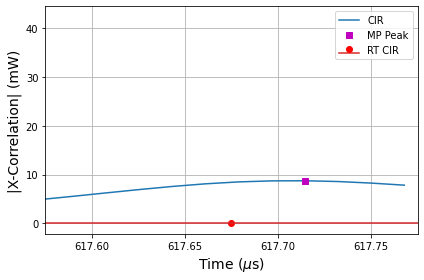

RT CIR at 630.7403714285715 microseconds is 26.085714285841277 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 8.766
Scaled RT CIR amplitude: 0.012


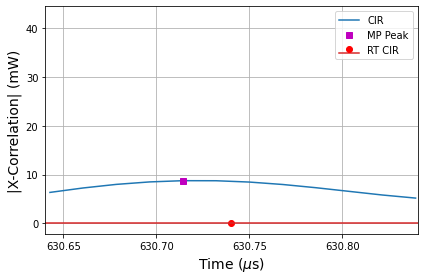

RT CIR at 561.8211514285715 microseconds is 53.84857142848887 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.025
Scaled RT CIR amplitude: 0.698


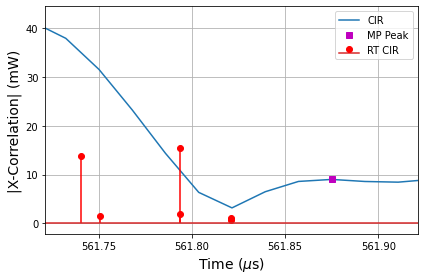

RT CIR at 561.8210014285714 microseconds is 53.9985714285649 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.025
Scaled RT CIR amplitude: 1.221


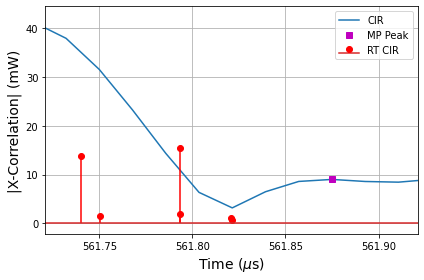

RT CIR at 561.7505614285715 microseconds is 36.275714285807226 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 41.316
Scaled RT CIR amplitude: 1.563


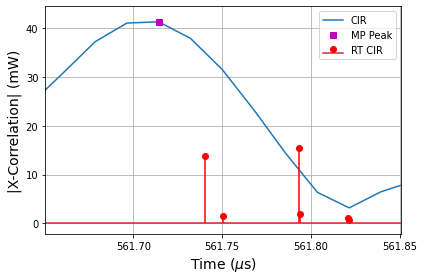

RT CIR at 561.7404214285715 microseconds is 26.135714285828726 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 41.316
Scaled RT CIR amplitude: 13.843


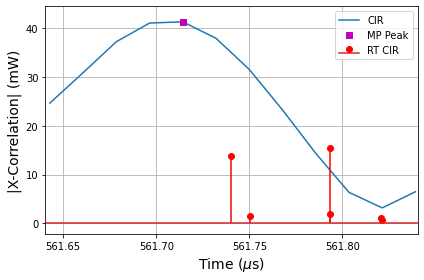

RT CIR at 561.6314614285715 microseconds is 77.89000000002488 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 42.359
Scaled RT CIR amplitude: 8.98


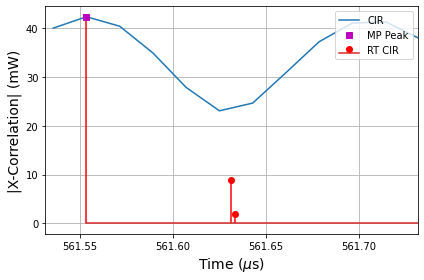

RT CIR at 561.7934914285714 microseconds is 79.20571428576295 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 41.316
Scaled RT CIR amplitude: 1.905


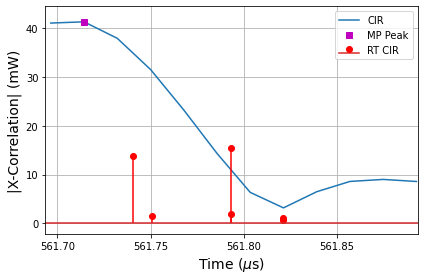

RT CIR at 561.6331914285714 microseconds is 79.61999999997715 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 42.359
Scaled RT CIR amplitude: 1.867


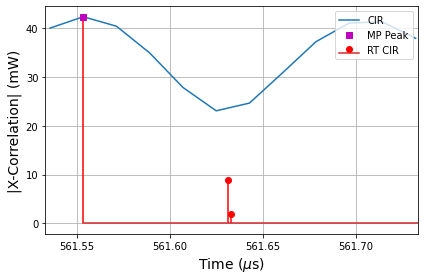

RT CIR at 562.3584814285714 microseconds is 34.37571428571573 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.268
Scaled RT CIR amplitude: 0.004


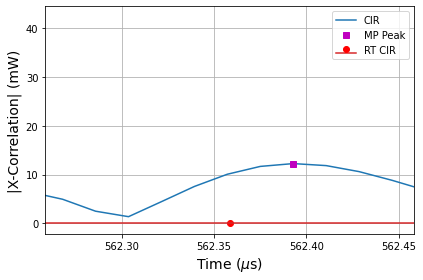

Number of total peaks: 68
Number of Non-matching Peaks: 56
Number of Peaks close in time (ns): 12
Number of Matching Peaks (time and amplitude): 1

0 pre-peak bucket peak matches.
Peak bucket matches (within 0.2 microseconds of peak): 1/3 --> 33.33333333333333% match rate
Post-peak bucket matches: 0/65 --> 0.0% match rate

 ----- PLOTNUM: 4, TX: cnode-mario-dd-b210, RX: cnode-ebc-dd-b210 ----- 



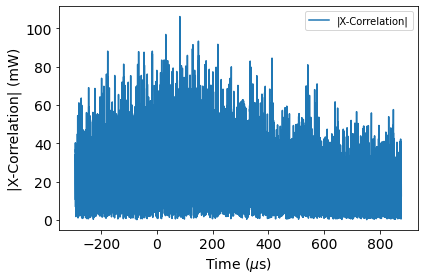

mario-ebc
RX Time Delay: 82.39285714285714 us
Unmatched max amplitude Tau (RT): 230.3586 us
Max amplitude measured CIR, with time adjustment: 2140.2451571428574 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.023732554179943275


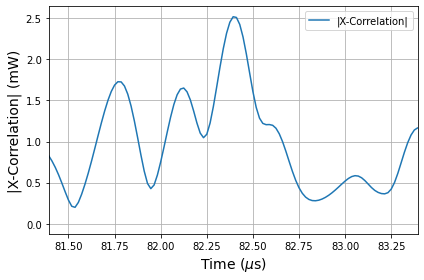

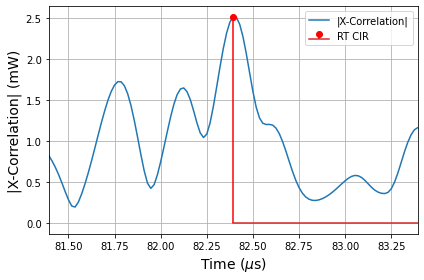

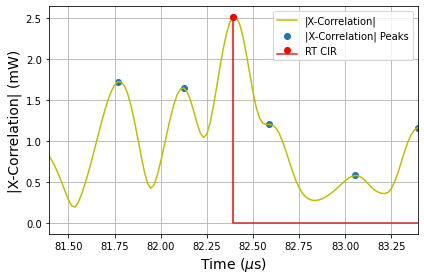

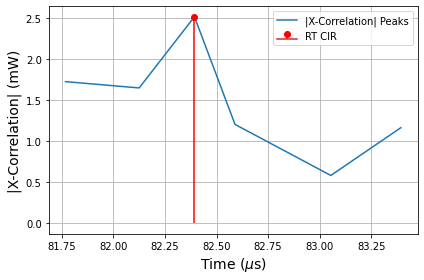

-- Total Received Power --
RT: 6.34 W
CIR (local peaks): 15.21 W
CIR (full): 32288.99 W

-- RMS Delay Spread --
RT: 0.0 us
CIR (local peaks): 0.43615376644315573 us


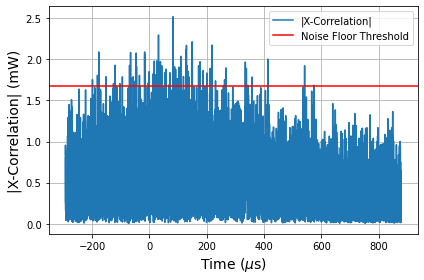

noise_std threshold: 1.6709925267764871
RT CIR at 82.39285714285714 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 2.518
Scaled RT CIR amplitude: 2.518

MATCH


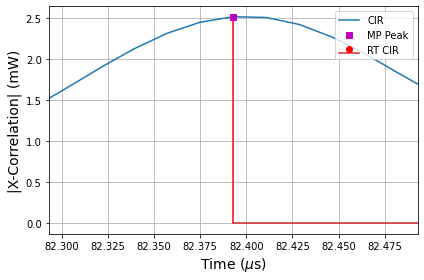

Number of total peaks: 10
Number of Non-matching Peaks: 9
Number of Peaks close in time (ns): 1
Number of Matching Peaks (time and amplitude): 1

0 pre-peak bucket peak matches.
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/9 --> 0.0% match rate

 ----- PLOTNUM: 5, TX: cnode-mario-dd-b210, RX: cnode-ustar-dd-b210 ----- 



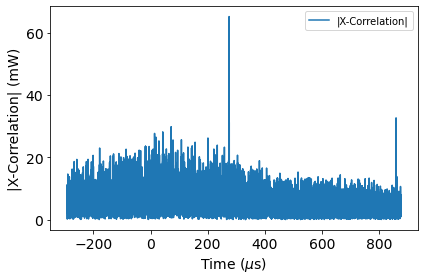

mario-ustar
RX Time Delay: 275.44642857142856 us
Unmatched max amplitude Tau (RT): 679.58013 us
Max amplitude measured CIR, with time adjustment: 2333.2987285714285 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.000481505402907516


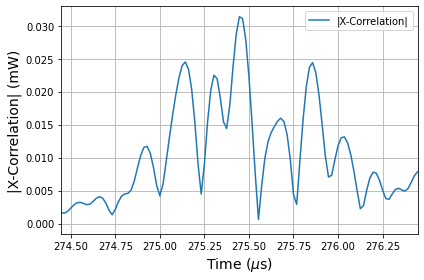

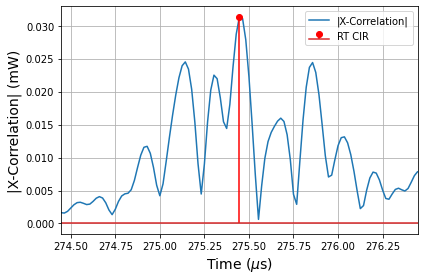

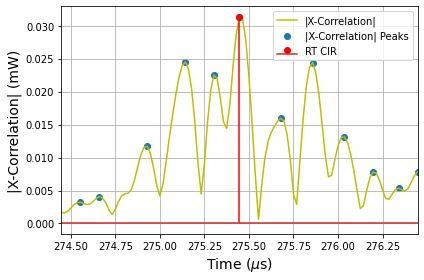

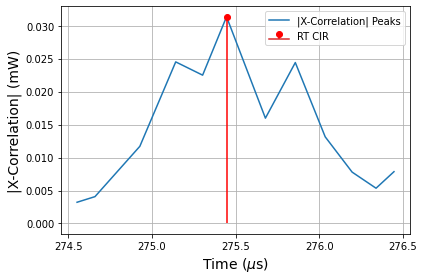

-- Total Received Power --
RT: 0.0 W
CIR (local peaks): 0.0 W
CIR (full): 0.94 W

-- RMS Delay Spread --
RT: 0.0 us
CIR (local peaks): 0.3429041749563474 us


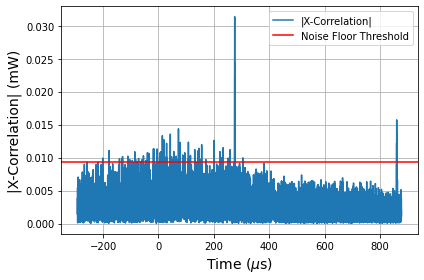

noise_std threshold: 0.009356480843080484
RT CIR at 275.44642857142856 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 0.031
Scaled RT CIR amplitude: 0.031

MATCH


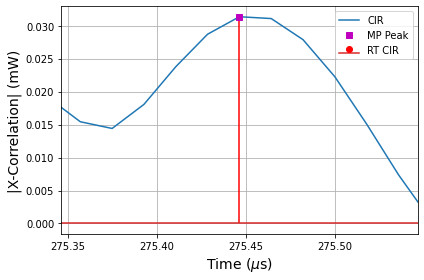

Number of total peaks: 10
Number of Non-matching Peaks: 9
Number of Peaks close in time (ns): 1
Number of Matching Peaks (time and amplitude): 1

Pre-peak bucket matches: 0/5 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/4 --> 0.0% match rate

 ----- PLOTNUM: 6, TX: cnode-mario-dd-b210, RX: cnode-guesthouse-dd-b210 ----- 



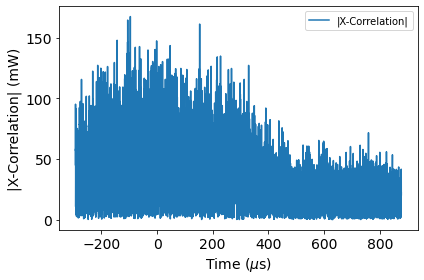

mario-guesthouse
RX Time Delay: -95.76785714285714 us
Unmatched max amplitude Tau (RT): 0.0 us
Max amplitude measured CIR, with time adjustment: 1962.084442857143 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.0


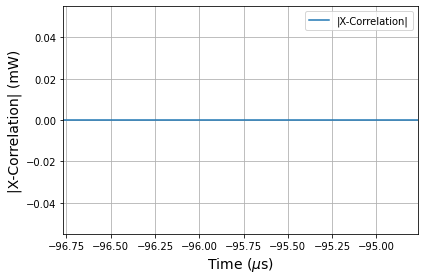

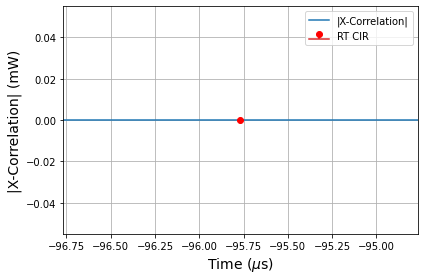

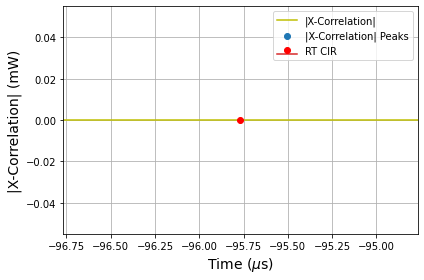


 ----- PLOTNUM: 7, TX: cnode-mario-dd-b210, RX: cnode-moran-dd-b210 ----- 



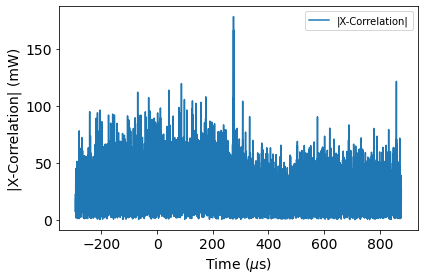

mario-moran
RX Time Delay: 274.75 us
Unmatched max amplitude Tau (RT): 134.41205 us
Max amplitude measured CIR, with time adjustment: 2332.6023 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.08435382320934542


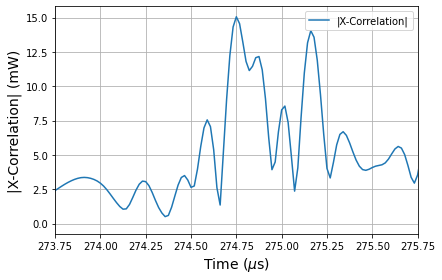

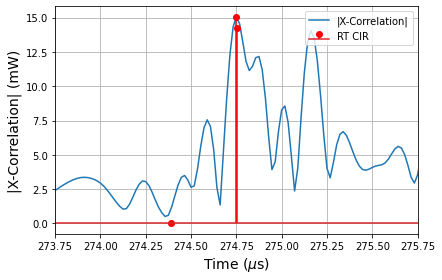

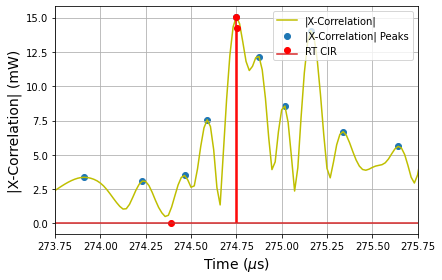

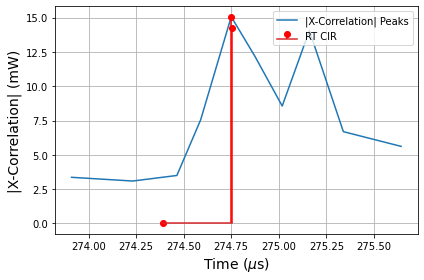

-- Total Received Power --
RT: 429.98 W
CIR (local peaks): 811.49 W
CIR (full): 518457.44 W

-- RMS Delay Spread --
RT: 0.002387319181721678 us
CIR (local peaks): 0.28955894295292656 us


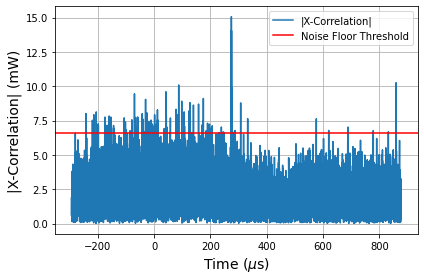

noise_std threshold: 6.620232480376469
RT CIR at 274.75467000000003 microseconds is 4.670000000032815 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 15.059
Scaled RT CIR amplitude: 14.255

MATCH


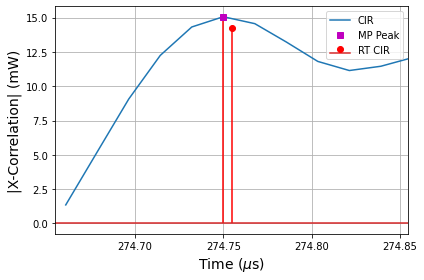

RT CIR at 274.75 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 15.059
Scaled RT CIR amplitude: 15.059

MATCH


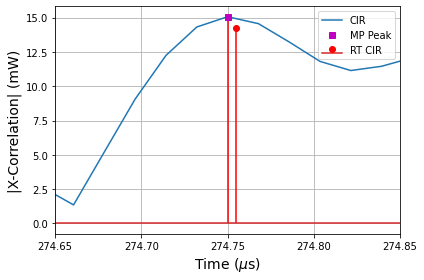

Number of total peaks: 6
Number of Non-matching Peaks: 4
Number of Peaks close in time (ns): 2
Number of Matching Peaks (time and amplitude): 2

Pre-peak bucket matches: 0/3 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 2/2 --> 100.0% match rate
Post-peak bucket matches: 0/1 --> 0.0% match rate

 ----- PLOTNUM: 8, TX: cnode-ustar-dd-b210, RX: cnode-ebc-dd-b210 ----- 



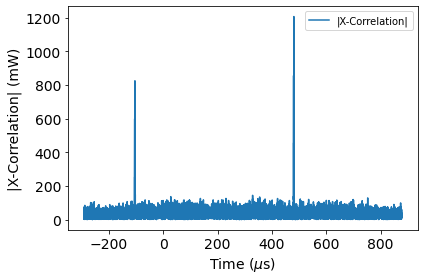

ustar-ebc
RX Time Delay: -104.71428571428571 us
Unmatched max amplitude Tau (RT): 86.685554 us
Max amplitude measured CIR, with time adjustment: 2538.2451571428574 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.0286277441601175


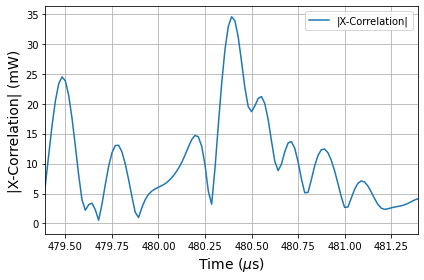

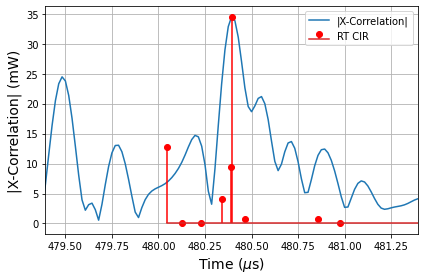

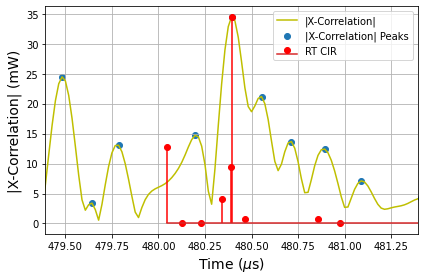

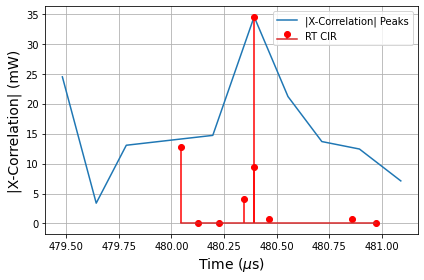

-- Total Received Power --
RT: 1462.44 W
CIR (local peaks): 3030.59 W
CIR (full): 139107.49 W

-- RMS Delay Spread --
RT: 0.11079423082938449 us
CIR (local peaks): 0.44506380284905056 us


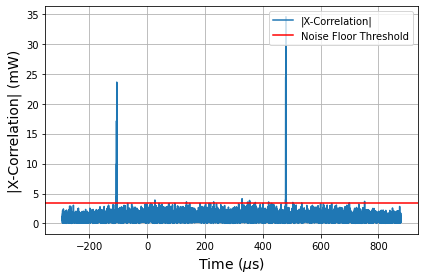

noise_std threshold: 3.4498763063775875
RT CIR at 480.3928571428571 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.521
Scaled RT CIR amplitude: 34.521

MATCH


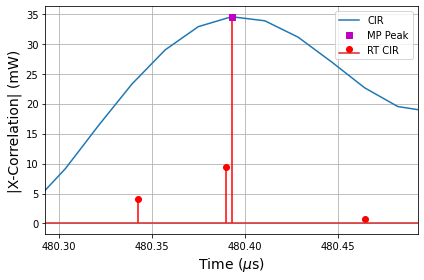

RT CIR at 480.1239931428571 microseconds is 72.43542857145258 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 14.71
Scaled RT CIR amplitude: 0.084


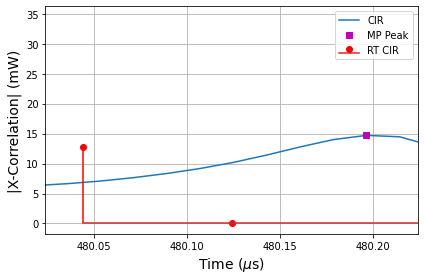

RT CIR at 480.2270231428571 microseconds is 30.594571428537165 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 14.71
Scaled RT CIR amplitude: 0.069


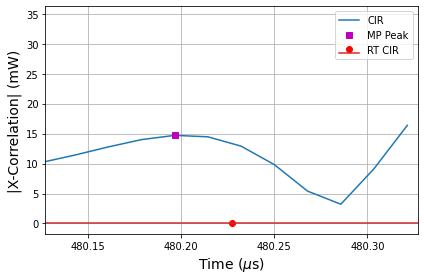

RT CIR at 480.8574231428571 microseconds is 35.434000000066135 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.43
Scaled RT CIR amplitude: 0.818


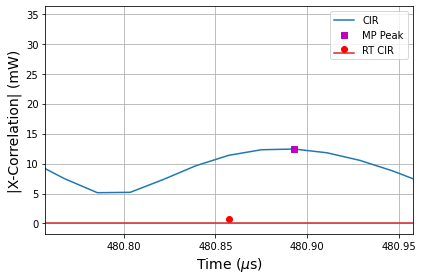

RT CIR at 480.4646831428571 microseconds is 71.82599999998729 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.521
Scaled RT CIR amplitude: 0.667


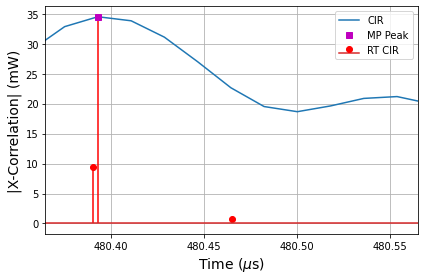

RT CIR at 480.3900891428571 microseconds is 2.7680000000032123 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.521
Scaled RT CIR amplitude: 9.387


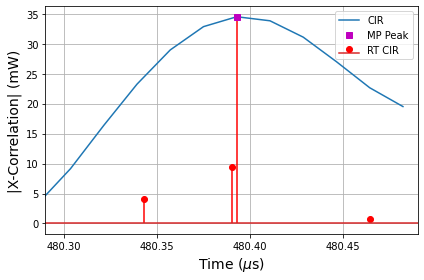

RT CIR at 480.3427831428571 microseconds is 50.07399999999507 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.521
Scaled RT CIR amplitude: 4.056


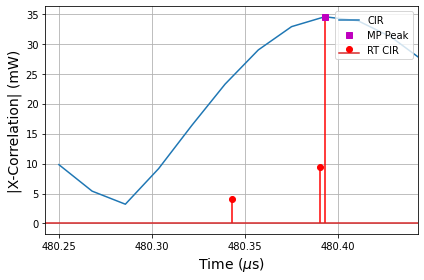

RT CIR at 480.97268314285714 microseconds is 79.82599999996864 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.43
Scaled RT CIR amplitude: 0.112


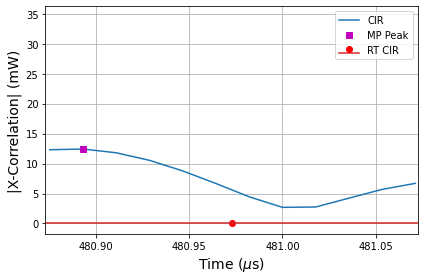

Number of total peaks: 83
Number of Non-matching Peaks: 75
Number of Peaks close in time (ns): 8
Number of Matching Peaks (time and amplitude): 1

Pre-peak bucket matches: 0/3 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/4 --> 25.0% match rate
Post-peak bucket matches: 0/76 --> 0.0% match rate

 ----- PLOTNUM: 9, TX: cnode-ustar-dd-b210, RX: cnode-mario-dd-b210 ----- 



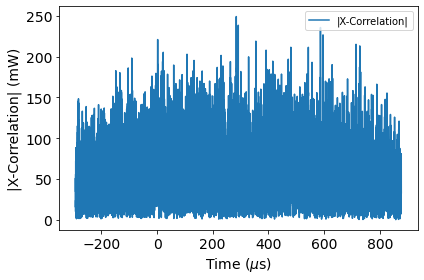

ustar-mario
RX Time Delay: 284.75 us
Unmatched max amplitude Tau (RT): 334.31271999999996 us
Max amplitude measured CIR, with time adjustment: 2342.6023 us

Amplitude matching adjustment ratio [xcorr/RT]: 8.841725154529954e-05


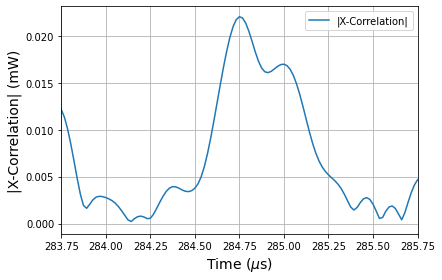

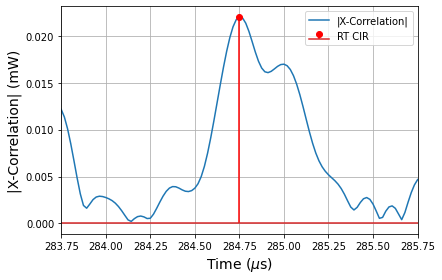

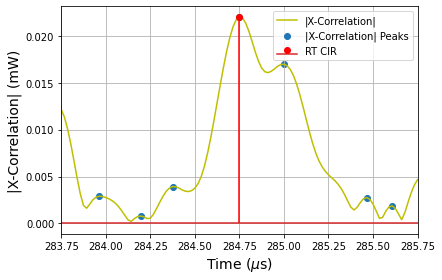

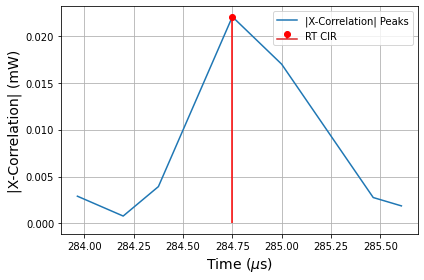

-- Total Received Power --
RT: 0.0 W
CIR (local peaks): 0.0 W
CIR (full): 2.84 W

-- RMS Delay Spread --
RT: 0.0 us
CIR (local peaks): 0.18058362420462432 us


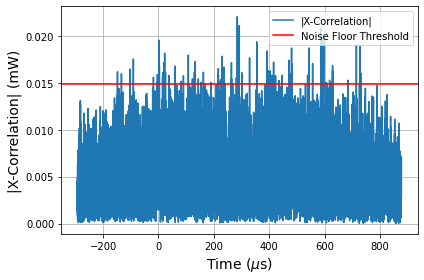

noise_std threshold: 0.014845877313968034
RT CIR at 284.75 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 0.022
Scaled RT CIR amplitude: 0.022

MATCH


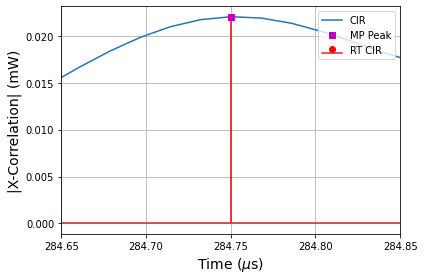

Number of total peaks: 10
Number of Non-matching Peaks: 9
Number of Peaks close in time (ns): 1
Number of Matching Peaks (time and amplitude): 1

Pre-peak bucket matches: 0/3 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/6 --> 0.0% match rate

 ----- PLOTNUM: 10, TX: cnode-ustar-dd-b210, RX: cnode-guesthouse-dd-b210 ----- 



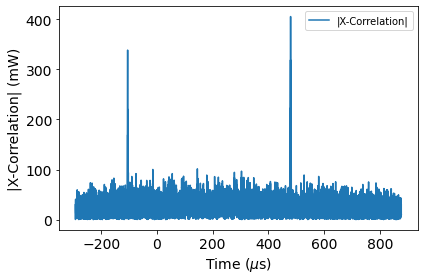

ustar-guesthouse
RX Time Delay: -105.125 us
Unmatched max amplitude Tau (RT): 128.78879 us
Max amplitude measured CIR, with time adjustment: 2537.8344428571427 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.053477150487815636


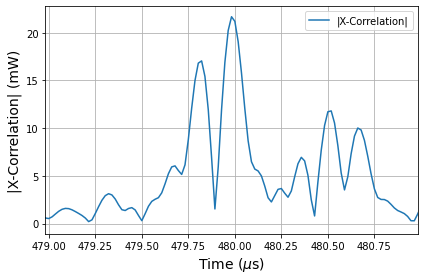

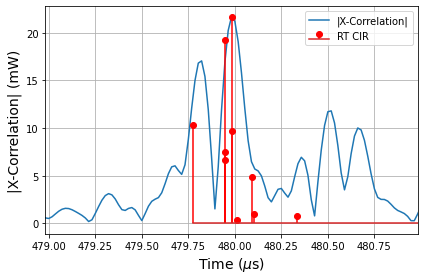

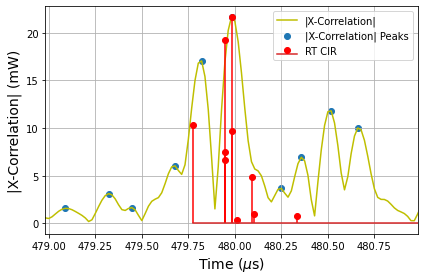

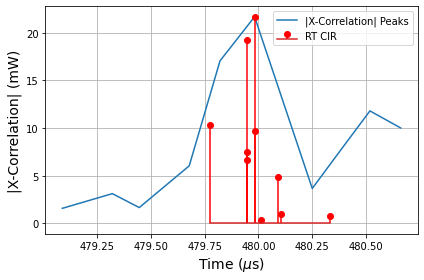

-- Total Received Power --
RT: 1165.35 W
CIR (local peaks): 1113.19 W
CIR (full): 196855.1 W

-- RMS Delay Spread --
RT: 0.06212053297985132 us
CIR (local peaks): 0.30490112910930683 us


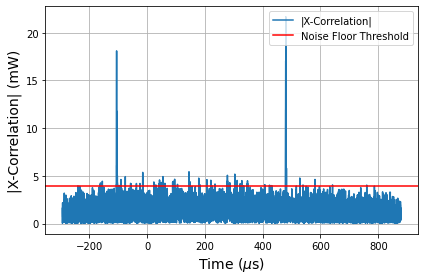

noise_std threshold: 3.892370673587191
RT CIR at 479.7731528571428 microseconds is 48.27571428575084 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 17.046
Scaled RT CIR amplitude: 10.293


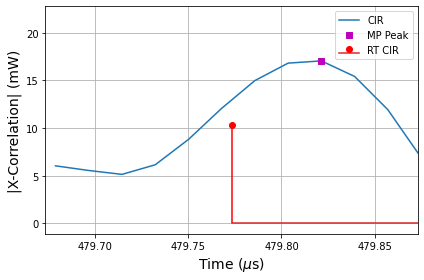

RT CIR at 479.94667285714286 microseconds is 35.469999999975244 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 19.211

MATCH


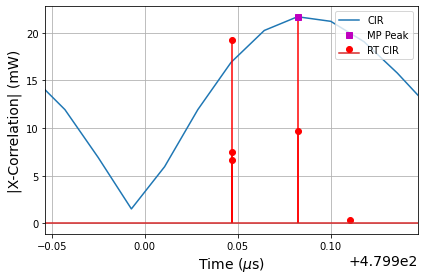

RT CIR at 479.98214285714283 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 21.676

MATCH


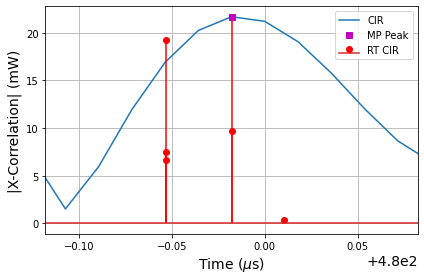

RT CIR at 479.9471828571428 microseconds is 34.960000000012315 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 7.472


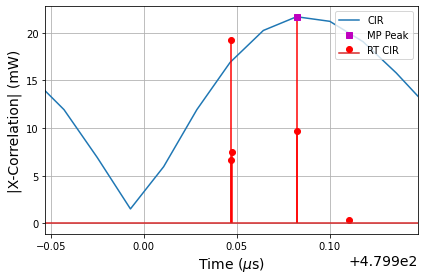

RT CIR at 479.9470128571428 microseconds is 35.13000000003785 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 6.65


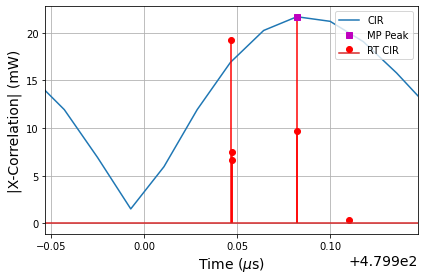

RT CIR at 479.98214285714283 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 9.718


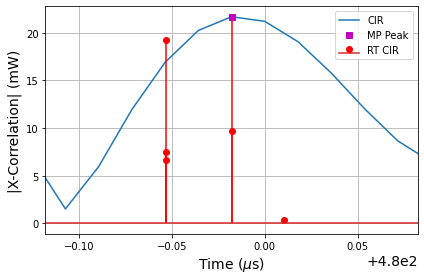

RT CIR at 480.0103728571428 microseconds is 28.229999999950905 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 21.676
Scaled RT CIR amplitude: 0.412


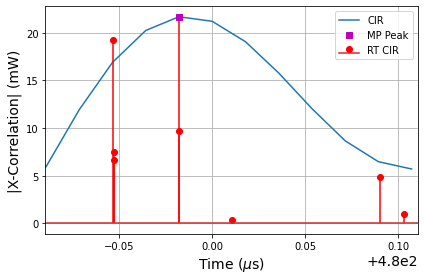

Number of total peaks: 70
Number of Non-matching Peaks: 63
Number of Peaks close in time (ns): 7
Number of Matching Peaks (time and amplitude): 2

Pre-peak bucket matches: 0/1 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 2/6 --> 33.33333333333333% match rate
Post-peak bucket matches: 0/63 --> 0.0% match rate

 ----- PLOTNUM: 11, TX: cnode-ustar-dd-b210, RX: cnode-moran-dd-b210 ----- 



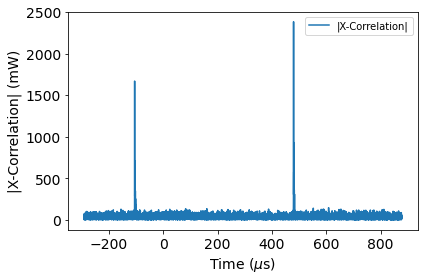

ustar-moran
RX Time Delay: -105.75 us
Unmatched max amplitude Tau (RT): 77.80261 us
Max amplitude measured CIR, with time adjustment: 2537.2273 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.014622739299405356


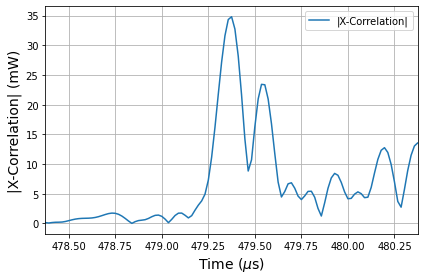

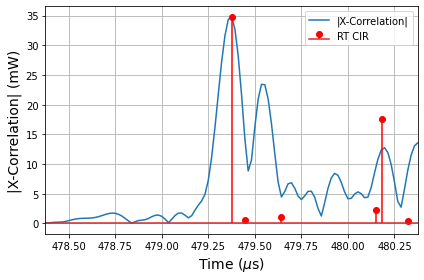

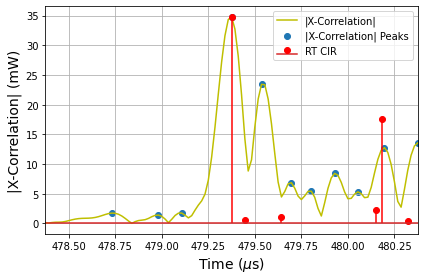

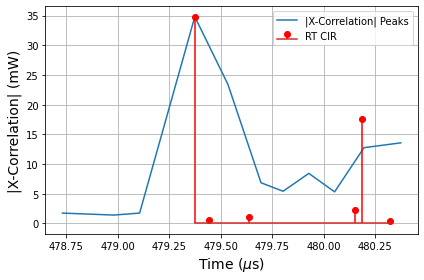

-- Total Received Power --
RT: 1528.78 W
CIR (local peaks): 2293.59 W
CIR (full): 51803.88 W

-- RMS Delay Spread --
RT: 0.3273976792860286 us
CIR (local peaks): 0.33088254846407195 us


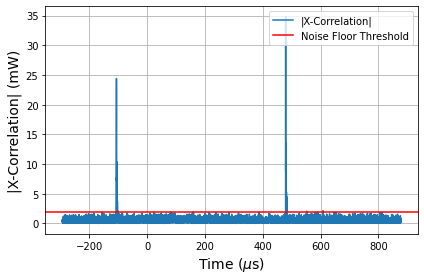

noise_std threshold: 1.9559456517192333
RT CIR at 479.375 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.825
Scaled RT CIR amplitude: 34.825

MATCH


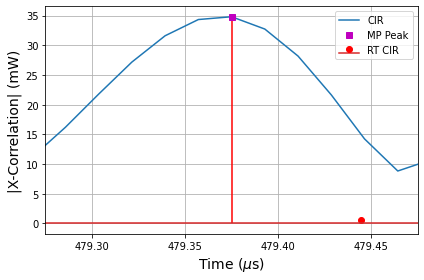

RT CIR at 480.185343 microseconds is 11.085571428566254 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.768
Scaled RT CIR amplitude: 17.585

MATCH


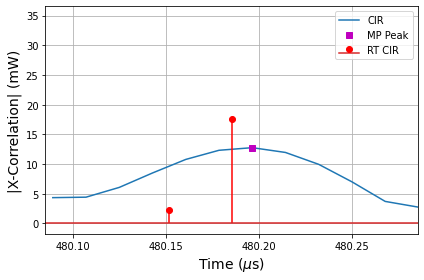

RT CIR at 480.15166999999997 microseconds is 44.75857142858786 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.768
Scaled RT CIR amplitude: 2.275


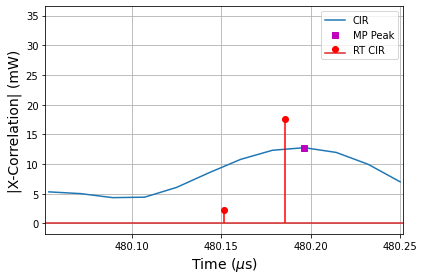

RT CIR at 479.444776 microseconds is 69.77599999999029 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.825
Scaled RT CIR amplitude: 0.573


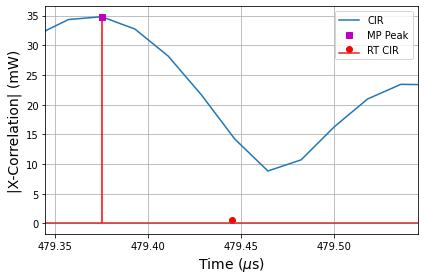

RT CIR at 480.32464 microseconds is 50.36000000001195 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 13.581
Scaled RT CIR amplitude: 0.454


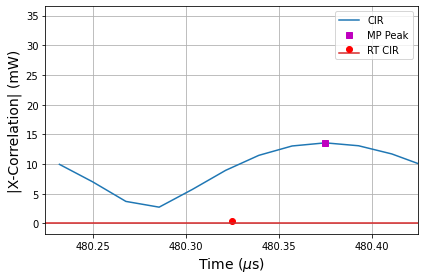

RT CIR at 479.640084 microseconds is 56.344571428553536 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 6.856
Scaled RT CIR amplitude: 1.029


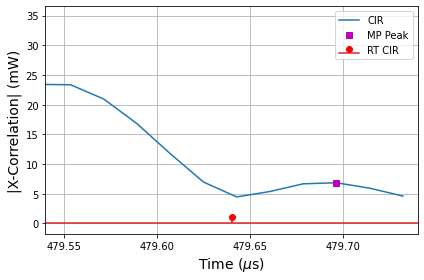

Number of total peaks: 65
Number of Non-matching Peaks: 59
Number of Peaks close in time (ns): 6
Number of Matching Peaks (time and amplitude): 2

Pre-peak bucket matches: 0/10 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/2 --> 50.0% match rate
Post-peak bucket matches: 1/53 --> 1.8867924528301887% match rate

 ----- PLOTNUM: 12, TX: cnode-guesthouse-dd-b210, RX: cnode-ebc-dd-b210 ----- 



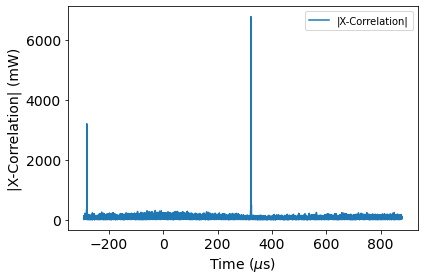

guesthouse-ebc
RX Time Delay: -281.5178571428571 us
Unmatched max amplitude Tau (RT): 59.80318 us
Max amplitude measured CIR, with time adjustment: 2380.1380142857142 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.009244677480063093


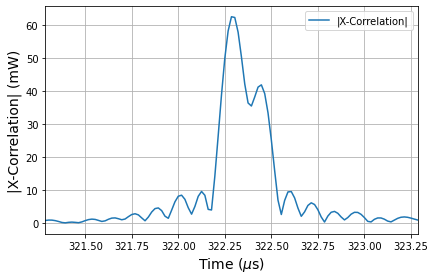

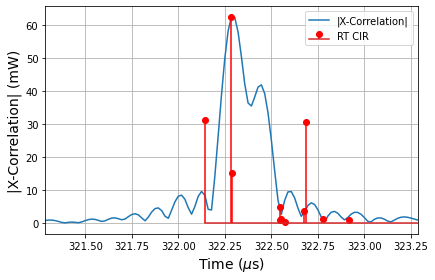

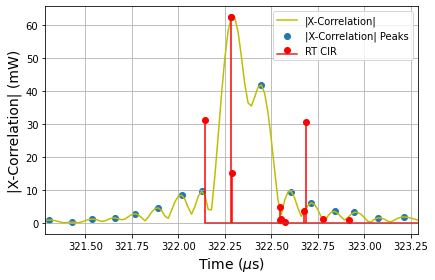

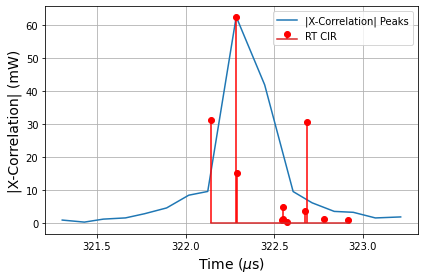

-- Total Received Power --
RT: 6149.47 W
CIR (local peaks): 6058.47 W
CIR (full): 82122.77 W

-- RMS Delay Spread --
RT: 0.16444993698604754 us
CIR (local peaks): 0.1138612776853691 us


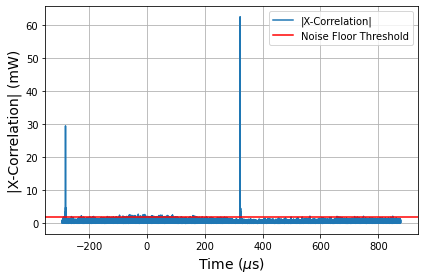

noise_std threshold: 1.8331892892904118
RT CIR at 322.1450442857143 microseconds is 20.04428571427752 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.703
Scaled RT CIR amplitude: 31.455


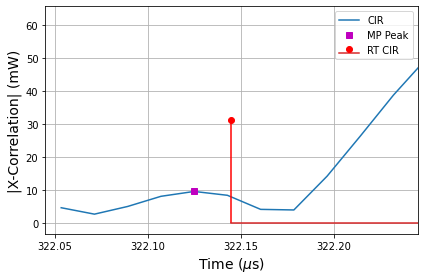

RT CIR at 322.2857142857143 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 62.653
Scaled RT CIR amplitude: 62.653

MATCH


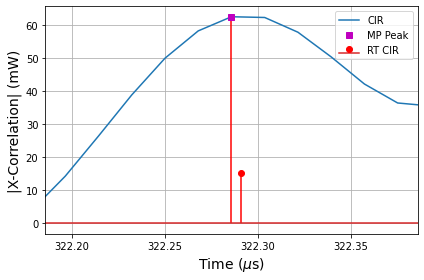

RT CIR at 322.6857642857143 microseconds is 78.62142857140952 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.667
Scaled RT CIR amplitude: 30.875


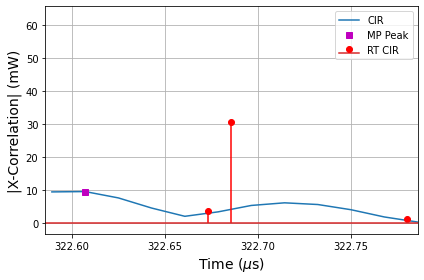

RT CIR at 322.2906442857143 microseconds is 4.930000000001655 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 62.653
Scaled RT CIR amplitude: 15.417


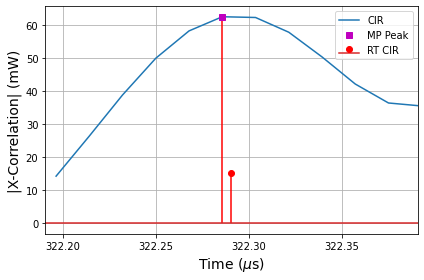

RT CIR at 322.54693428571426 microseconds is 60.208571428631785 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.667
Scaled RT CIR amplitude: 1.083


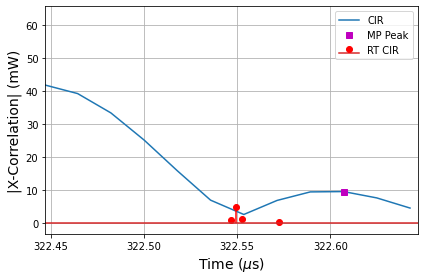

RT CIR at 322.5491542857143 microseconds is 57.98857142860925 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.667
Scaled RT CIR amplitude: 4.902


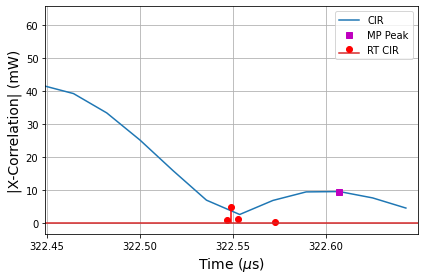

RT CIR at 322.5526982857143 microseconds is 54.44457142857573 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.667
Scaled RT CIR amplitude: 1.227


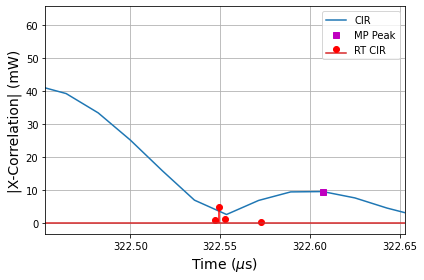

RT CIR at 322.5725482857143 microseconds is 34.59457142861311 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.667
Scaled RT CIR amplitude: 0.431


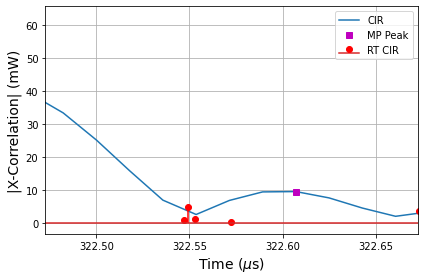

RT CIR at 322.67308128571426 microseconds is 65.93842857137133 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.667
Scaled RT CIR amplitude: 3.632


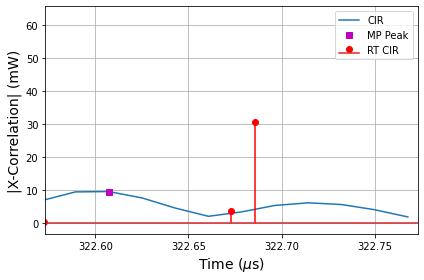

RT CIR at 322.7799242857143 microseconds is 65.63857142856477 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 6.256
Scaled RT CIR amplitude: 1.461


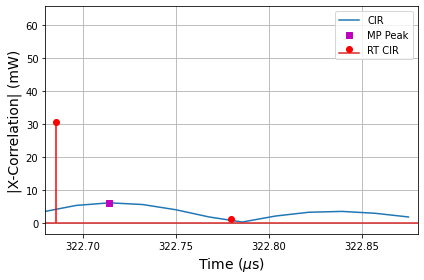

RT CIR at 322.9183212857143 microseconds is 79.03557142856243 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 3.655
Scaled RT CIR amplitude: 1.191


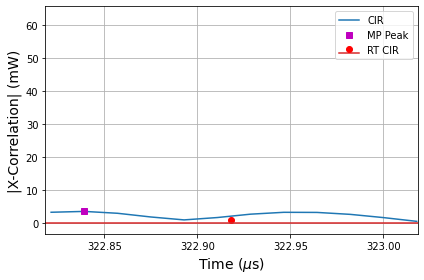

Number of total peaks: 67
Number of Non-matching Peaks: 56
Number of Peaks close in time (ns): 11
Number of Matching Peaks (time and amplitude): 1

Pre-peak bucket matches: 0/1 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/2 --> 50.0% match rate
Post-peak bucket matches: 0/64 --> 0.0% match rate

 ----- PLOTNUM: 13, TX: cnode-guesthouse-dd-b210, RX: cnode-mario-dd-b210 ----- 



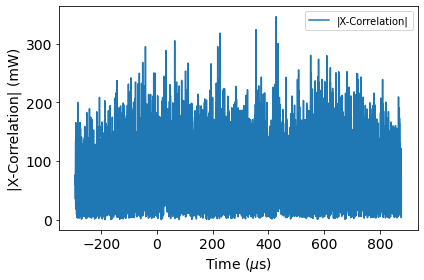

guesthouse-mario
RX Time Delay: 227.05357142857144 us
Unmatched max amplitude Tau (RT): 853.0908999999999 us
Max amplitude measured CIR, with time adjustment: 2486.3880142857142 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.0006316620460423805


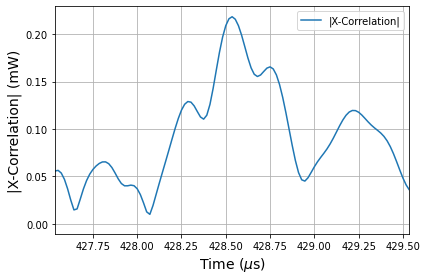

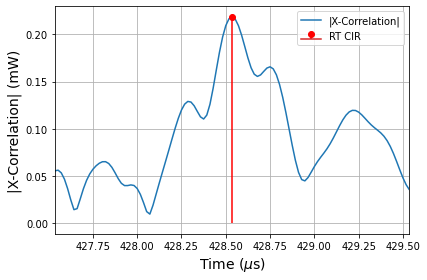

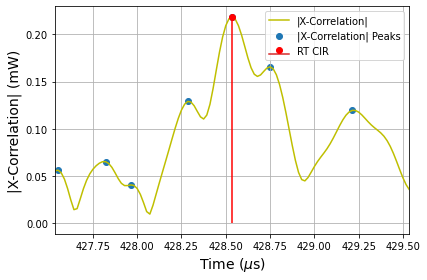


 ----- PLOTNUM: 14, TX: cnode-guesthouse-dd-b210, RX: cnode-ustar-dd-b210 ----- 



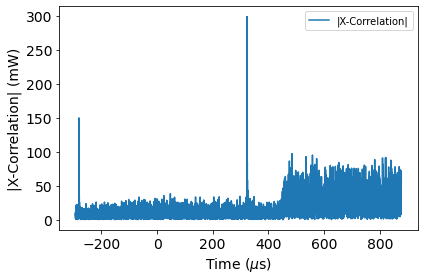

guesthouse-ustar
RX Time Delay: -280.75 us
Unmatched max amplitude Tau (RT): 128.78879 us
Max amplitude measured CIR, with time adjustment: 2380.9237285714285 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.07586195488053273


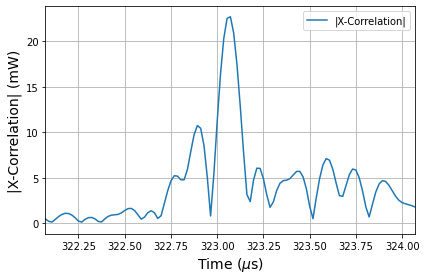

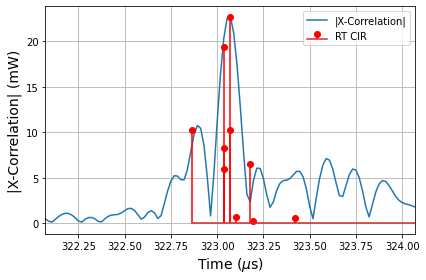

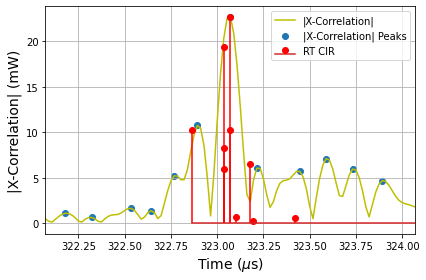

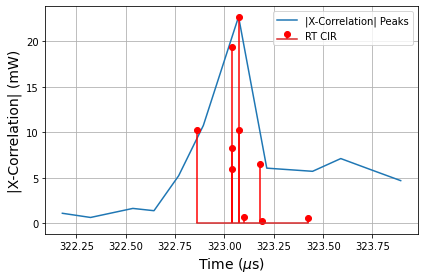

-- Total Received Power --
RT: 1250.7 W
CIR (local peaks): 842.65 W
CIR (full): 221390.86 W

-- RMS Delay Spread --
RT: 0.062075033676335885 us
CIR (local peaks): 0.254947795863002 us


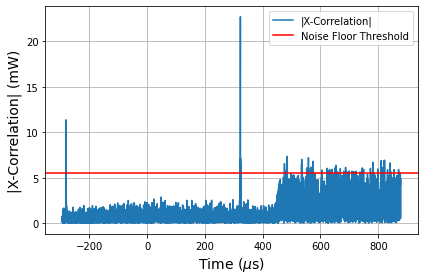

noise_std threshold: 5.523496151637796
RT CIR at 322.8624385714286 microseconds is 30.41857142858362 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.754
Scaled RT CIR amplitude: 10.293

MATCH


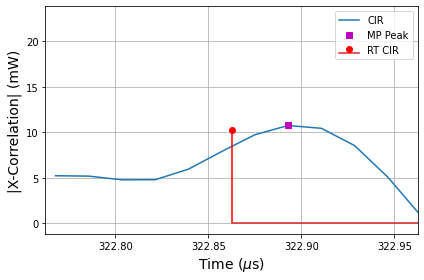

RT CIR at 323.03595857142864 microseconds is 35.469999999975244 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 19.412

MATCH


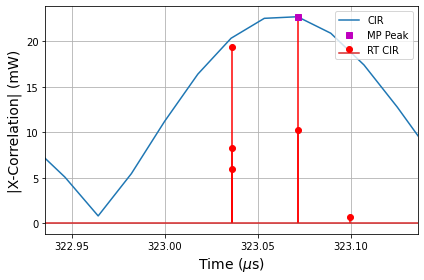

RT CIR at 323.0714285714286 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 22.692

MATCH


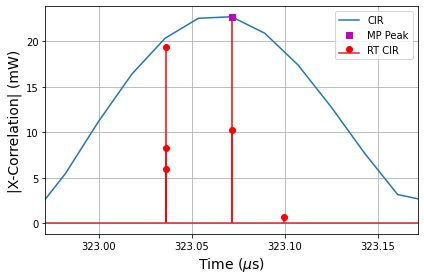

RT CIR at 323.1921885714286 microseconds is 22.09714285714881 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 6.072
Scaled RT CIR amplitude: 0.229


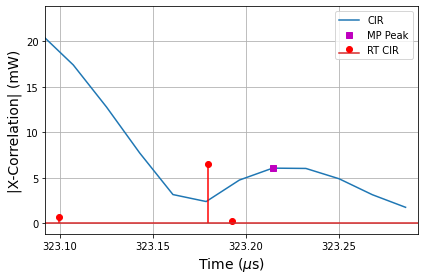

RT CIR at 323.0714285714286 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 10.307


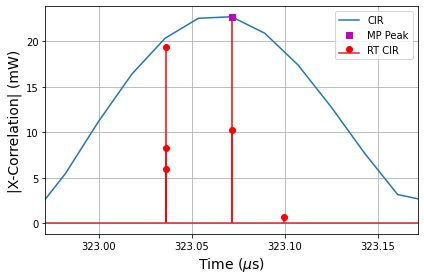

RT CIR at 323.09965857142856 microseconds is 28.229999999950905 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 0.717


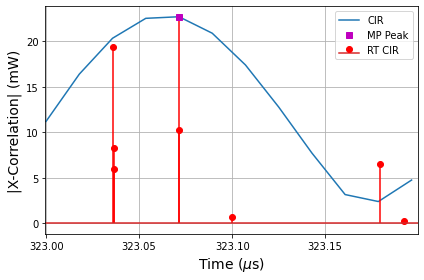

RT CIR at 323.0364685714286 microseconds is 34.960000000012315 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 8.257


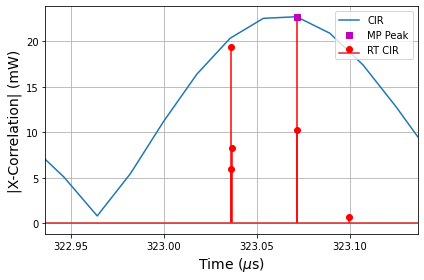

RT CIR at 323.0362985714286 microseconds is 35.13000000003785 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 22.692
Scaled RT CIR amplitude: 5.941


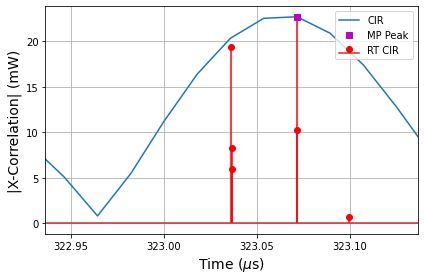

RT CIR at 323.1794985714286 microseconds is 34.787142857112485 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 6.072
Scaled RT CIR amplitude: 6.508

MATCH


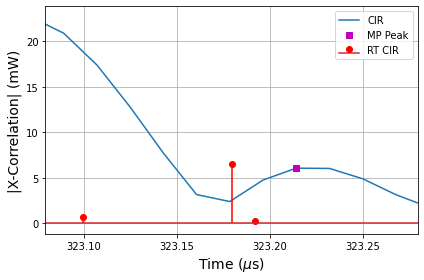

RT CIR at 323.4229585714286 microseconds is 23.46999999997479 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 5.725
Scaled RT CIR amplitude: 0.582


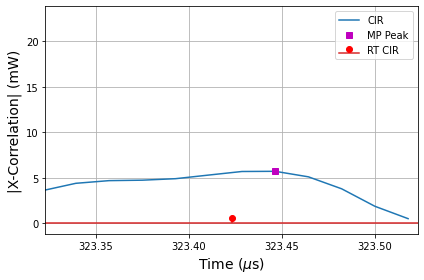

Number of total peaks: 70
Number of Non-matching Peaks: 60
Number of Peaks close in time (ns): 10
Number of Matching Peaks (time and amplitude): 4

Pre-peak bucket matches: 1/1 --> 100.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 2/6 --> 33.33333333333333% match rate
Post-peak bucket matches: 1/63 --> 1.5873015873015872% match rate

 ----- PLOTNUM: 15, TX: cnode-guesthouse-dd-b210, RX: cnode-moran-dd-b210 ----- 



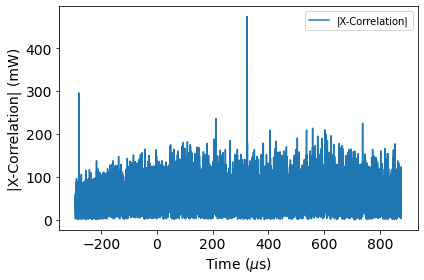

guesthouse-moran
RX Time Delay: -280.5535714285714 us
Unmatched max amplitude Tau (RT): 115.50284 us
Max amplitude measured CIR, with time adjustment: 2381.1201571428574 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.07319418837314874


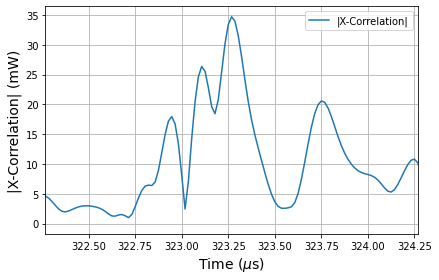

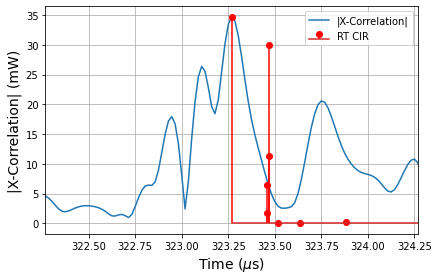

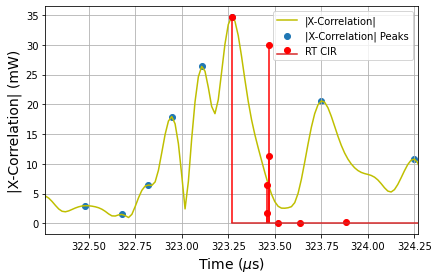

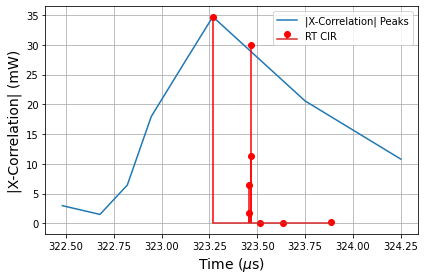

-- Total Received Power --
RT: 2279.9 W
CIR (local peaks): 2814.32 W
CIR (full): 1708003.05 W

-- RMS Delay Spread --
RT: 0.09911903203282288 us
CIR (local peaks): 0.3124190710331988 us


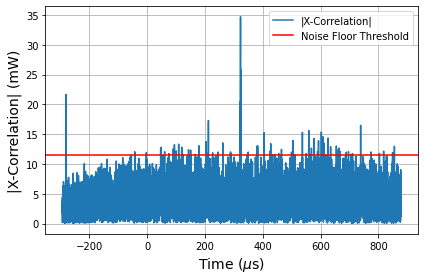

noise_std threshold: 11.454392817102198
RT CIR at 323.26785714285717 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.708
Scaled RT CIR amplitude: 34.708

MATCH


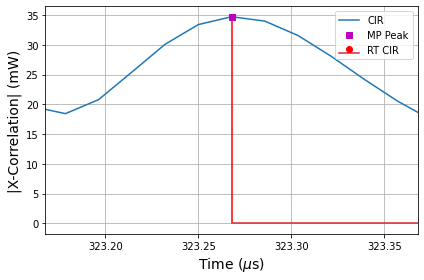

Number of total peaks: 49
Number of Non-matching Peaks: 48
Number of Peaks close in time (ns): 1
Number of Matching Peaks (time and amplitude): 1

0 pre-peak bucket peak matches.
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/48 --> 0.0% match rate

 ----- PLOTNUM: 16, TX: cnode-moran-dd-b210, RX: cnode-ebc-dd-b210 ----- 



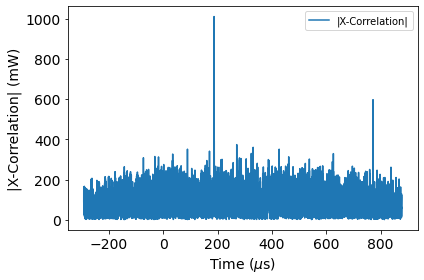

moran-ebc
RX Time Delay: 186.98214285714286 us
Unmatched max amplitude Tau (RT): 107.94108 us
Max amplitude measured CIR, with time adjustment: 2244.8344428571427 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.041934062777351816


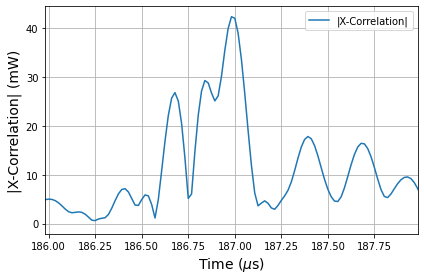

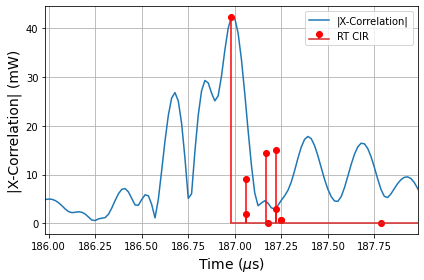

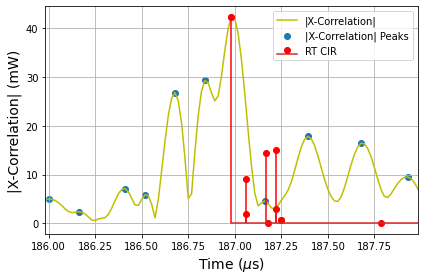

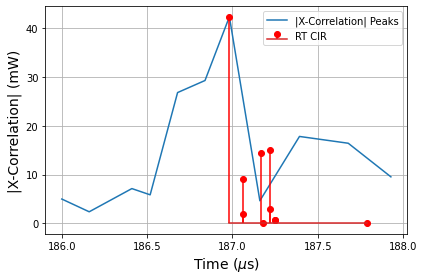

-- Total Received Power --
RT: 2324.23 W
CIR (local peaks): 4189.01 W
CIR (full): 1499846.94 W

-- RMS Delay Spread --
RT: 0.08524128034398111 us
CIR (local peaks): 0.31016297928241854 us


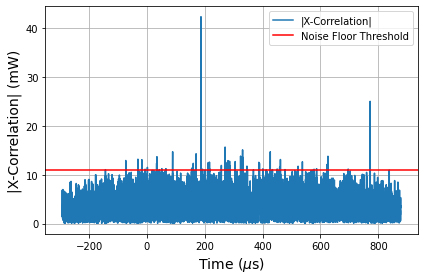

noise_std threshold: 10.873469859154895
RT CIR at 186.98214285714286 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 42.359
Scaled RT CIR amplitude: 42.359

MATCH


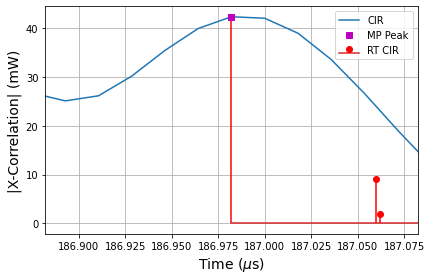

RT CIR at 323.6479328571429 microseconds is 84.20999999992773 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 13.747
Scaled RT CIR amplitude: 0.005


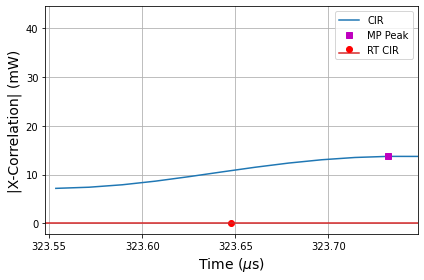

RT CIR at 280.45396285714287 microseconds is 63.894285714297894 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 12.892
Scaled RT CIR amplitude: 0.103


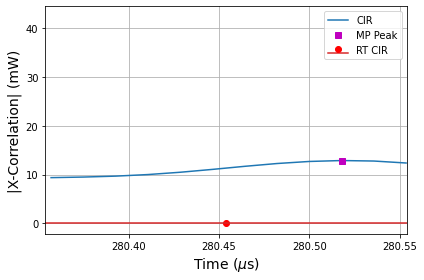

RT CIR at 187.06176285714287 microseconds is 79.62000000000558 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 42.359
Scaled RT CIR amplitude: 1.894


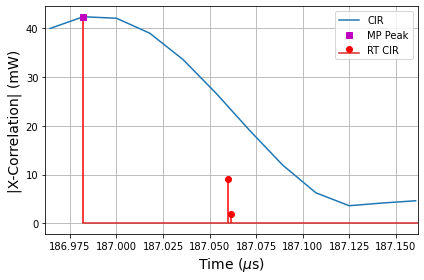

RT CIR at 187.06003285714286 microseconds is 77.88999999999646 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 42.359
Scaled RT CIR amplitude: 9.05


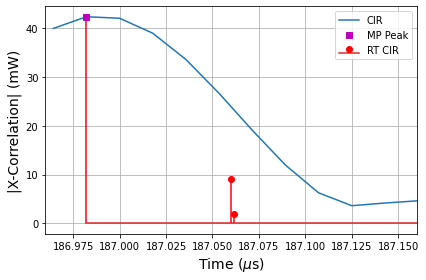

RT CIR at 209.99646285714286 microseconds is 67.89142857141428 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 10.998
Scaled RT CIR amplitude: 0.007


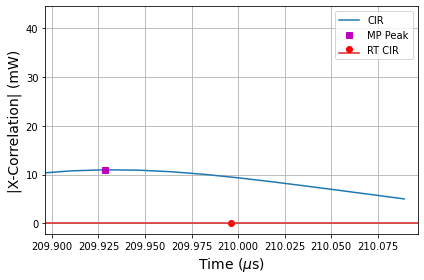

Number of total peaks: 69
Number of Non-matching Peaks: 63
Number of Peaks close in time (ns): 6
Number of Matching Peaks (time and amplitude): 1

0 pre-peak bucket peak matches.
Peak bucket matches (within 0.2 microseconds of peak): 1/3 --> 33.33333333333333% match rate
Post-peak bucket matches: 0/66 --> 0.0% match rate

 ----- PLOTNUM: 17, TX: cnode-moran-dd-b210, RX: cnode-mario-dd-b210 ----- 



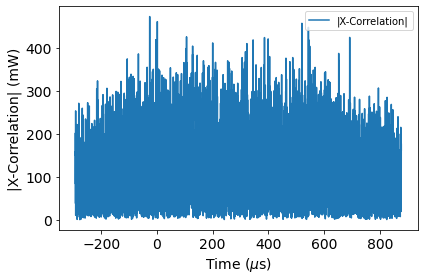

moran-mario
RX Time Delay: -25.91071428571429 us
Unmatched max amplitude Tau (RT): 134.41206 us
Max amplitude measured CIR, with time adjustment: 2031.9415857142858 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.0263529728407375


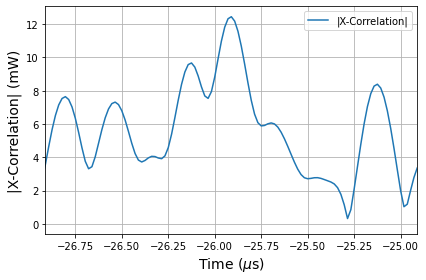

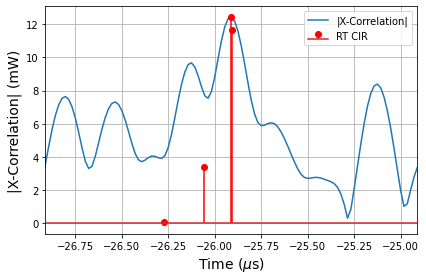

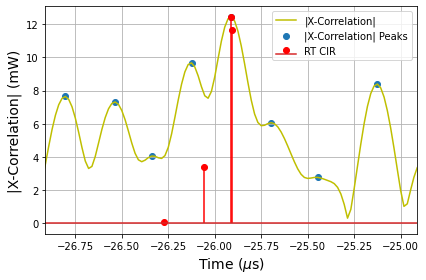

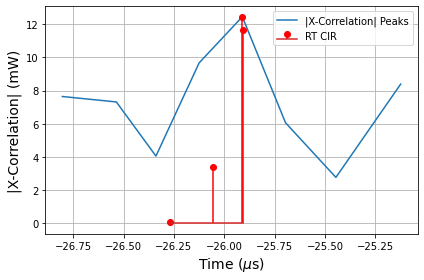

-- Total Received Power --
RT: 302.47 W
CIR (local peaks): 491.9 W
CIR (full): 1015840.62 W

-- RMS Delay Spread --
RT: 0.02888709312009505 us
CIR (local peaks): 0.4884889738588855 us


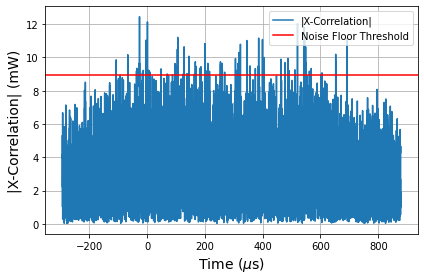

noise_std threshold: 8.950767351157971
Number of total peaks: 8
Number of Non-matching Peaks: 8
Number of Peaks close in time (ns): 0
Number of Matching Peaks (time and amplitude): 0

Pre-peak bucket matches: 0/4 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 0/2 --> 0.0% match rate
Post-peak bucket matches: 0/2 --> 0.0% match rate

 ----- PLOTNUM: 18, TX: cnode-moran-dd-b210, RX: cnode-ustar-dd-b210 ----- 



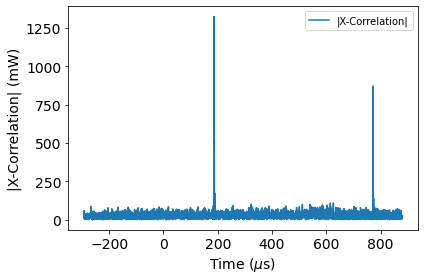

moran-ustar
RX Time Delay: 186.41071428571428 us
Unmatched max amplitude Tau (RT): 77.802605 us
Max amplitude measured CIR, with time adjustment: 2244.2630142857142 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.01849443617559388


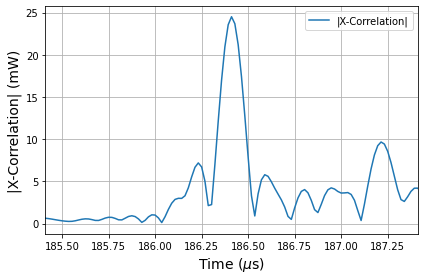

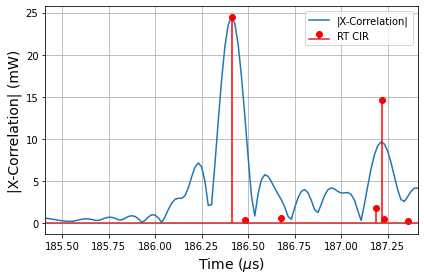

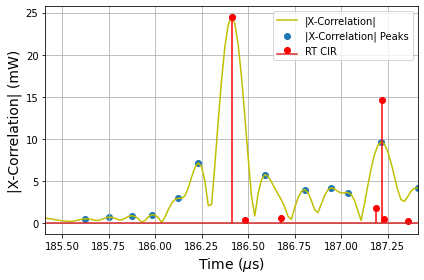

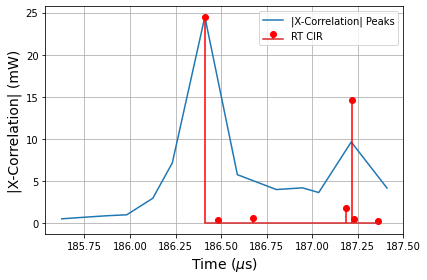

-- Total Received Power --
RT: 820.27 W
CIR (local peaks): 855.63 W
CIR (full): 34745.75 W

-- RMS Delay Spread --
RT: 0.3582799889439318 us
CIR (local peaks): 0.3076283665354017 us


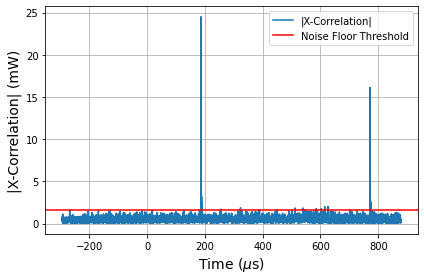

noise_std threshold: 1.5913436322224224
RT CIR at 187.50115928571427 microseconds is 90.44499999998834 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 4.194
Scaled RT CIR amplitude: 0.035


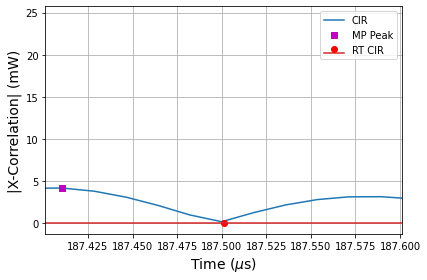

RT CIR at 187.22106228571425 microseconds is 6.776571428531497 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.66
Scaled RT CIR amplitude: 14.673


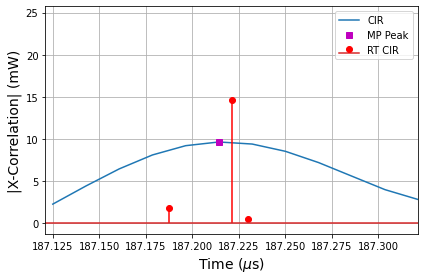

RT CIR at 187.1873892857143 microseconds is 26.896428571433262 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.66
Scaled RT CIR amplitude: 1.84


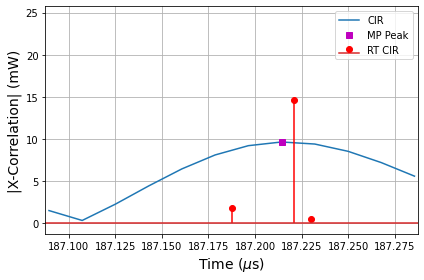

RT CIR at 187.22984528571428 microseconds is 15.559571428553909 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 9.66
Scaled RT CIR amplitude: 0.52


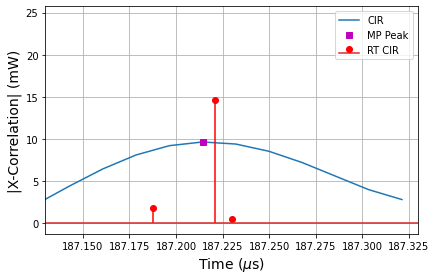

RT CIR at 186.41071428571428 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 24.507
Scaled RT CIR amplitude: 24.507

MATCH


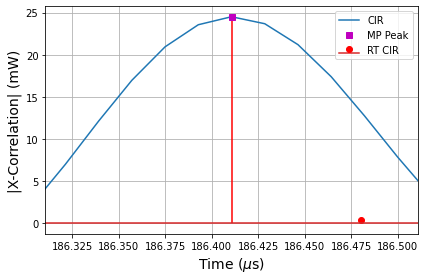

RT CIR at 186.48049528571428 microseconds is 69.78100000000609 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 24.507
Scaled RT CIR amplitude: 0.405


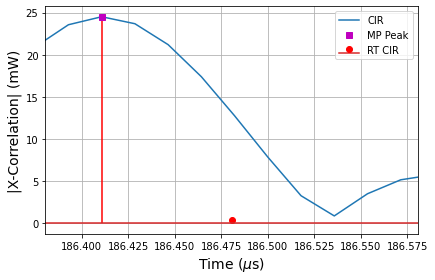

RT CIR at 187.36035928571425 microseconds is 50.355000000024575 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 4.194
Scaled RT CIR amplitude: 0.301


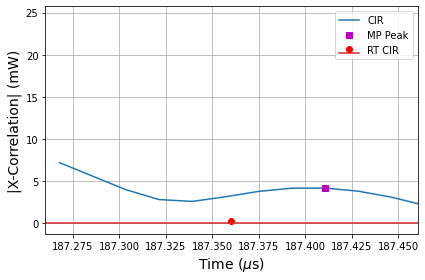

RT CIR at 186.67580328571427 microseconds is 86.51757142854422 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 5.783
Scaled RT CIR amplitude: 0.678


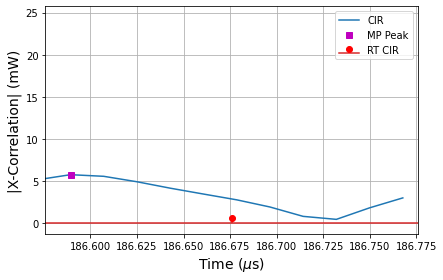

Number of total peaks: 68
Number of Non-matching Peaks: 60
Number of Peaks close in time (ns): 8
Number of Matching Peaks (time and amplitude): 1

Pre-peak bucket matches: 0/10 --> 0.0% match rate
Peak bucket matches (within 0.2 microseconds of peak): 1/2 --> 50.0% match rate
Post-peak bucket matches: 0/56 --> 0.0% match rate

 ----- PLOTNUM: 19, TX: cnode-moran-dd-b210, RX: cnode-guesthouse-dd-b210 ----- 



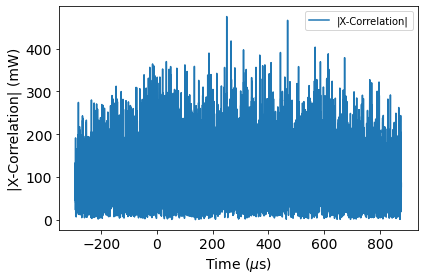

moran-guesthouse
RX Time Delay: 250.67857142857144 us
Unmatched max amplitude Tau (RT): 115.50284 us
Max amplitude measured CIR, with time adjustment: 2308.5308714285716 us

Amplitude matching adjustment ratio [xcorr/RT]: 0.07305479227564422


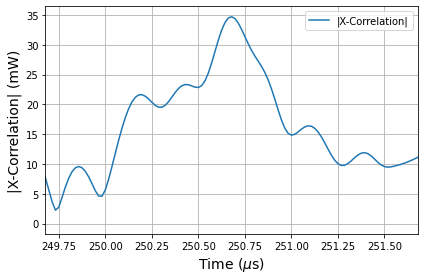

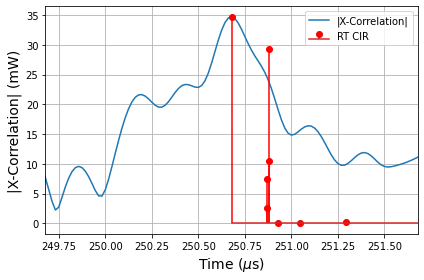

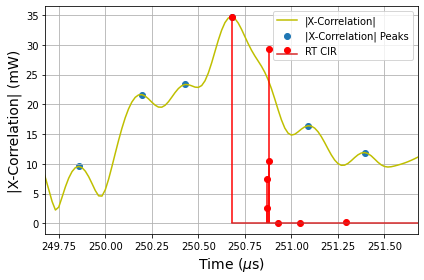

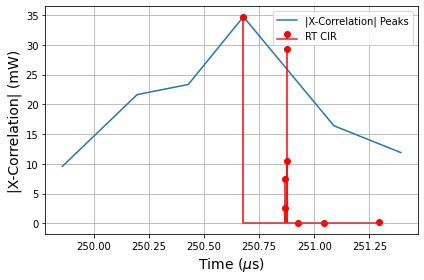

-- Total Received Power --
RT: 2231.0 W
CIR (local peaks): 2719.86 W
CIR (full): 6920273.18 W

-- RMS Delay Spread --
RT: 0.09889203781755196 us
CIR (local peaks): 0.3342295331690716 us


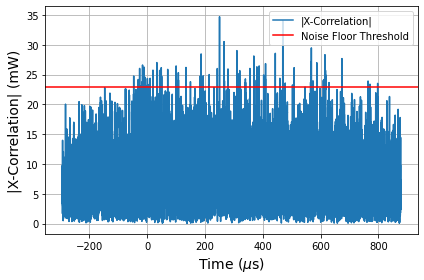

noise_std threshold: 22.955505518125765
RT CIR at 250.67857142857144 microseconds is 0.0 ns away from measured multipath peak.
Measured Multipath Peak amplitude: 34.708
Scaled RT CIR amplitude: 34.708

MATCH


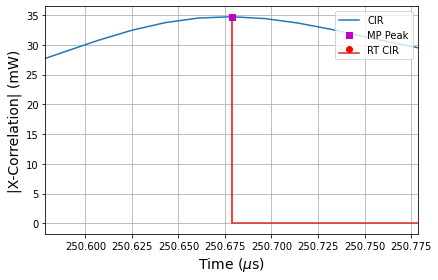

Number of total peaks: 51
Number of Non-matching Peaks: 50
Number of Peaks close in time (ns): 1
Number of Matching Peaks (time and amplitude): 1

0 pre-peak bucket peak matches.
Peak bucket matches (within 0.2 microseconds of peak): 1/1 --> 100.0% match rate
Post-peak bucket matches: 0/50 --> 0.0% match rate
Results File Written.


In [8]:
# Cross Correlation & Delays

# matching x axis
def xaxis_match(oldx, peak, oldy):
    my = oldy.index(max(oldy))
    newx = [(x - oldx[my] + peak) for x in oldx]
    return newx

def yaxis_match(oldy, peak):
    #my = oldy.index(max(oldy))
    my = np.argmax(oldy)
    if oldy[my] == 0:
        oldy[my] = 1
    newy = [y * (peak/oldy[my]) for y in oldy]
    return newy, (peak/oldy[my])

# Finding peak in area around RT multipath
def find_multipath_peak(local_cir):
    len_local = len(local_cir)
    
    for i in range(len_local):
        larger_than_prev = False
        larger_than_post = False
        
        if (i > 0) and (local_cir[i] >= local_cir[i-1]):
            larger_than_prev = True
        if (i < len_local - 1) and (local_cir[i] >= local_cir[i+1]):
            larger_than_post = True
        
        if larger_than_prev and larger_than_post:
            return i # index of peak element

def find_nearest_element(local_cir, value):
    local_cir = np.asarray(local_cir)
    near_ind = (np.abs(local_cir - value)).argmin()
    return near_ind #, local_cir[near_ind]

##filtered_rx0_list = []
##pairnames = []
##kernel_dists = []
amp_ratios = []
total_peaks = []
match_percentages = []
total_peak = 0
total_match = 0
totalrpower = []
totalrmsdelay = []
prebuckets = []
surbuckets = []
postbuckets = []
total_pre = 0
total_sur = 0
total_post = 0
total_pre_match = 0
total_sur_match = 0
total_post_match = 0
plotnum = 0

### CIR ANALYSIS FOR ALL LINKS IN DATA -- LOOP ###

for tx in txlocs:
    for rx in rxlocs:
        if tx != rx:
            for repNum in range(rxrepeat):
                txloc = tx
                rxloc = rx
                
                print('\n ----- PLOTNUM: ' + str(plotnum) + ', TX: ' + txloc + ', RX: ' + rxloc + ' ----- \n')

                rx_data[txloc] = np.vstack(rx_data[txloc])
                rxloc_arr = np.array(txrxloc[txloc])
                rx0 = rx_data[txloc][rxloc_arr==rxloc][repNum]

                # Low Pass Filtering to out_of_band frequency components
                stopband_attenuation = 60.0
                transition_bandwidth = 0.05
                cutoff_norm = 0.15
                filterN, beta = signal.kaiserord(stopband_attenuation, transition_bandwidth)
                taps = signal.firwin(filterN, cutoff_norm, window=('kaiser', beta))
                filtered_rx0 = signal.lfilter(taps, 1.0, rx0)
                ##filtered_rx0_list.append(filtered_rx0)

                packetSignal = QPSK_samples
                lagIndex, lags, xcorr_mag, peak = crossCorrelationMax(filtered_rx0, packetSignal)
                ##print('Plotnum: ' + str(plotnum) + ', TX: ' + txloc + ', RX: ' + rxloc)
                plotnum += 1
                
                # Find associated RT results in JSON
                tname = txloc.split('-')[1]
                rname = rxloc.split('-')[1]
                pairname = tname + '-' + rname
                ##pairnames.append(pairname)
                print(pairname)
                # "tx-rx": [f_rttau, f_rta]
                ##f_rttau = rt_json[pairname][0] #x
                ##f_rta = rt_json[pairname][1] #y
                
                # starting loop for looking further at CIR in comparison to RT with algorithm
                ##filtered_rx0 = filtered_rx0_list[plotnum]
                ##pairname = pairnames[plotnum]
                ##print(pairname)

                ##lagIndex, lags, xcorr_mag, peak = crossCorrelationMax(filtered_rx0, QPSK_samples)
                print('RX Time Delay: ' + str(samples_to_us(lagIndex,samp_rate)) + ' us')
                
                T0_watch = 2057.8523 # for EBC-Guesthouse link
                us_around = 2
                lagIndex_us = samples_to_us(lagIndex,samp_rate)
                PlagIndex_us = lagIndex_us + T0_watch
                lags_adjusted = ((lags/samp_rate)*1000000) + T0_watch
                
                
                #RT CIR results
                f_rttau = rt_json[pairname][0] #x
                f_rta = rt_json[pairname][1] #y

                #RT results from seconds to us to match CIR plot
                tau = [x * 100000000 for x in f_rttau]
                a = [x * 1000000 for x in f_rta]
                maxy = a.index(max(a))
                unmatched_taumax = tau[maxy]
                print('Unmatched max amplitude Tau (RT): ' + str(unmatched_taumax) + ' us')

                peak_ind = np.where(lags == peak)[0][0]
                peakIndex_us = samples_to_us(peak,samp_rate)
                PpeakIndex_us = peakIndex_us + T0_watch
                print('Max amplitude measured CIR, with time adjustment: ' + str(PpeakIndex_us) + ' us\n')

                tau_plot = xaxis_match(tau, peakIndex_us, a)
                #a_plot, amp_ratio = yaxis_match(a, xcorr_mag[peak_ind])
                xcorr_mag, amp_ratio = yaxis_match(xcorr_mag, max(a))
                a_plot = a
                
                amp_ratios.append(amp_ratio)
                print('Amplitude matching adjustment ratio [xcorr/RT]: ' + str(amp_ratio))

                Ptau_plot = [x + T0_watch for x in tau_plot]

                # figure 4 plot
                
                lags_adjusted = lags_adjusted - T0_watch
                Ptau_plot = [x - T0_watch for x in Ptau_plot]
                PpeakIndex_us = PpeakIndex_us - T0_watch
                
                plt.figure()
                plt.plot(lags_adjusted, xcorr_mag, label='|X-Correlation|')
                #plt.stem(Ptau_plot, a_plot, label='RT CIR', linefmt='r-', markerfmt='ro')
                #plt.stem(Ptau_plot, a, label='RT CIR', linefmt='g-', markerfmt='go')
                plt.legend(loc='upper right')
                plt.ylabel('|X-Correlation| (mW)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                #plt.xlim((Ptau_plot[1]-1,Ptau_plot[1]+1))
                plt.xlim((PpeakIndex_us-1,PpeakIndex_us+1))
                plt.tight_layout()
                plt.grid(True)
                plt.show()
                
                plt.figure()
                plt.plot(lags_adjusted, xcorr_mag, label='|X-Correlation|')
                plt.stem(Ptau_plot, a_plot, label='RT CIR', linefmt='r-', markerfmt='ro')
                #plt.stem(Ptau_plot, a, label='RT CIR', linefmt='g-', markerfmt='go')
                plt.legend(loc='upper right')
                plt.ylabel('|X-Correlation| (mW)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                #plt.xlim((Ptau_plot[1]-1,Ptau_plot[1]+1))
                plt.xlim((PpeakIndex_us-1,PpeakIndex_us+1))
                plt.tight_layout()
                plt.grid(True)
                plt.show()

                # Calculations & Plots for Total Received Power and RMS Delay Spread

                #finding local peaks for measured CIR
                peak_indicies, _ = find_peaks(xcorr_mag)
                peaks = []
                peaks_lags = []
                for each in peak_indicies:
                    peaks.append(xcorr_mag[each])
                    peaks_lags.append(lags[each])
                peaks = np.array(peaks)
                peaks_lags = np.array(peaks_lags)

                # Local Peaks CIR Identified
                plt.figure()
                plt.plot(lags_adjusted, xcorr_mag, 'y', label='|X-Correlation|') #, linefmt='y:'
                plt.scatter((((peaks_lags/samp_rate)*1000000)), peaks, label='|X-Correlation| Peaks')
                plt.stem(Ptau_plot, a_plot, label='RT CIR', linefmt='r-', markerfmt='ro')
                plt.legend(loc='upper right')
                plt.ylabel('|X-Correlation| (mW)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                #plt.xlim((Ptau_plot[1]-1,Ptau_plot[1]+1))
                plt.xlim((PpeakIndex_us-1,PpeakIndex_us+1))
                plt.tight_layout()
                plt.grid(True)
                plt.show()

                # cropping to approximately 1us around peak of interest
                sindex = 0
                slook = True
                eindex = 0
                elook = False

                for index,value in enumerate(peaks_lags):
                    if ((value/samp_rate)*1000000) > (peakIndex_us-1) and slook:
                        sindex = index
                        slook = False
                        elook = True
                    if elook and ((value/samp_rate)*1000000) > (peakIndex_us+1):
                        eindex = index
                        break

                peaks_cropped = peaks[sindex:eindex]
                peaks_lags_cropped = peaks_lags[sindex:eindex]

                # cropping for RT 1us around peak of interest
                sindex = 0
                slook = True
                eindex = 0
                elook = False

                pairs_plot = []
                for index, value in enumerate(tau_plot):
                    pairs_plot.append([tau_plot[index], a_plot[index]])

                pairs_plot.sort(key=lambda tauele: tauele[0])
                a_plot_cropped = []
                tau_plot_cropped = []
                for each in pairs_plot:
                    tau_plot_cropped.append(each[0])
                    a_plot_cropped.append(each[1])
                tau_plot_cropped = np.array(tau_plot_cropped)
                a_plot_cropped = np.array(a_plot_cropped)

                for index,value in enumerate(tau_plot_cropped):
                    if value > (peakIndex_us-1) and slook:
                        sindex = index
                        slook = False
                        elook = True
                    if elook and value > (peakIndex_us+1):
                        eindex = index
                        break

                tau_plot_cropped = tau_plot_cropped[sindex:eindex]
                a_plot_cropped = a_plot_cropped[sindex:eindex]
                
                if len(tau_plot_cropped) == 0:
                    #tau_plot_cropped = np.array(tau_plot)
                    continue

                lags_cropped = ((peaks_lags_cropped/samp_rate)*1000000)
                
#                 #####
#                 lags_cropped = lags_adjusted - T0_watch
#                 Ptau_plot = [x - T0_watch for x in Ptau_plot]
#                 PpeakIndex_us = PpeakIndex_us - T0_watch
#                 ####

                # Local Peaks CIR Identified & Cropped to approximately 1us around peak of interest
                plt.figure()
                plt.plot(lags_cropped, peaks_cropped, label='|X-Correlation| Peaks')
                plt.stem(tau_plot_cropped, a_plot_cropped, label='RT CIR', linefmt='r-', markerfmt='ro')
                plt.legend(loc='upper right')
                plt.ylabel('|X-Correlation| (mW)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.tight_layout()
                plt.grid(True)
                plt.show()

                # Received Power Calculations (using cropped data)
                # P = sum[amplitudes]^2
                cir_power_peaks = 0
                cir_power = 0
                rt_power = 0
                for each in peaks_cropped:
                    cir_power_peaks += (each**2)
                for each in xcorr_mag:
                    cir_power += (each**2)
                for each in a_plot_cropped:
                    rt_power += (each**2)

                print('-- Total Received Power --')
                print('RT: ' + str(round(rt_power,2)) + ' W') #/1000000
                print('CIR (local peaks): ' + str(round(cir_power_peaks,2)) + ' W')
                print('CIR (full): ' + str(round(cir_power,2)) + ' W')
                
                # (CIR local peaks, RT)
                totalrpowerstr = '(' + str(round(cir_power_peaks,2)) + ' W, ' + str(round(rt_power,2)) + ' W)'
                totalrpower.append(totalrpowerstr)

                # RMS Delay Spread Calculations (using cropped data)
                # \tau_{rms} = \sqrt{\frac{\sum{P_h(\tau)*\tau^2}}{\sum{P_h(\tau)}} - 
                #                   (\frac{\sum{P_h(\tau)*\tau}}{\sum{P_h(\tau)}})^2}

                #cir calculation
                tlags_cropped = lags_cropped - lags_cropped[0]
                num1 = 0
                denom = 0
                num2 = 0
                for i,p in enumerate(peaks_cropped):
                    powerht = p**2

                    num1 += powerht*tlags_cropped[i]
                    denom += powerht

                    num2 += powerht*(tlags_cropped[i]**2)

                tau_mean = num1/denom
                tau_bar_sq = num2/denom
                CIRtrms = math.sqrt(tau_bar_sq - (tau_mean**2))

                #rt calculation
                ttau_plot_cropped = tau_plot_cropped - tau_plot_cropped[0]
                num1 = 0
                denom = 0
                num2 = 0
                for i,p in enumerate(a_plot_cropped):
                    powerht = p**2

                    num1 += powerht*ttau_plot_cropped[i]
                    denom += powerht

                    num2 += powerht*(ttau_plot_cropped[i]**2)

                tau_mean = num1/denom
                tau_bar_sq = num2/denom
                RTtrms = math.sqrt(tau_bar_sq - (tau_mean**2))

                print('\n-- RMS Delay Spread --')
                print('RT: ' + str(RTtrms) + ' us')
                print('CIR (local peaks): ' + str(CIRtrms) + ' us')
                
                # (CIR local peaks, RT)
                totalrmsdelaystr = '(' + str(CIRtrms) + ' us, ' + str(RTtrms) + ' us)'
                totalrmsdelay.append(totalrmsdelaystr)

                # Calculating noise floor for link

                noise_buffer = 25
                noise_arr = np.concatenate((xcorr_mag[:peak_ind-noise_buffer], xcorr_mag[peak_ind+noise_buffer:]))

                second_peak = max(noise_arr)
                second_peak_ind = np.where(noise_arr == second_peak)[0][0]

                noisearr = np.concatenate((noise_arr[:second_peak_ind-noise_buffer], noise_arr[second_peak_ind+noise_buffer:]))

                noise_std = np.std(noisearr)
                noise_std_thresh = 3.4*np.sqrt(2)*noise_std

                plt.figure()
                plt.plot(lags_adjusted, xcorr_mag, label='|X-Correlation|')
                plt.axhline(y = noise_std_thresh, color = 'r', linestyle = '-', label='Noise Floor Threshold')
                plt.legend(loc='upper right')
                plt.ylabel('|X-Correlation| (mW)', fontsize=14)
                plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                plt.xticks(fontsize=10)
                plt.yticks(fontsize=10)
                plt.tight_layout()
                plt.grid(True)
                plt.show()

                print('noise_std threshold: ' + str(noise_std_thresh))

                # peak finding algorithm
                stau = find_nearest_element(lags, tau_plot[0])
                cir_cropped = xcorr_mag[stau:]
                lags_cropped = ((lags[stau:]/samp_rate)*1000000)
                limit = 0.1 # 100ns in us

                #a_ind = 1
                #for each in a[1:]:
                a_ind = 0
                non_match_count = 0
                match_count = 0
                ns_match_count = 0
                
                # buckets for matching peaks
                prebucket_count = 0
                surbucket_count = 0
                postbucket_count = 0
                
                prebucket_match = 0
                surbucket_match = 0
                postbucket_match = 0
                
                # PpeakIndex_us = peakIndex_us + T0_watch
                lowerbucket_lim = peakIndex_us - 0.1
                upperbucket_lim = peakIndex_us + 0.1
                
                for each in a_plot:
                    bucket = 0
                    lower_near_ind = find_nearest_element(lags_cropped, tau_plot[a_ind]-limit)
                    upper_near_ind = find_nearest_element(lags_cropped, tau_plot[a_ind]+limit)
                    cir_plot = cir_cropped[lower_near_ind:upper_near_ind+1]
                    lags_plot = lags_cropped[lower_near_ind:upper_near_ind+1]
                    
                    # checking bucket
                    if tau_plot[a_ind] <= lowerbucket_lim:
                        bucket = 1
                        prebucket_count += 1
                    elif tau_plot[a_ind] >= upperbucket_lim:
                        bucket = 3
                        postbucket_count += 1
                    else:
                        bucket = 2
                        surbucket_count += 1
                        
                    #print('bucket: ' + str(bucket))

                    local_peak_ind = find_multipath_peak(cir_plot)
                    if (local_peak_ind != None) and (cir_plot[local_peak_ind] >= noise_std_thresh):
                        peak_diff = abs(lags_plot[local_peak_ind]-tau_plot[a_ind])*1000
                        print(r'RT CIR at ' + str(tau_plot[a_ind]) + ' microseconds is ' + str(peak_diff) + ' ns away from measured multipath peak.')
                        if peak_diff <= 100: #if peaks within 100 ns of each other
                            print('Measured Multipath Peak amplitude: ' + str(round(cir_plot[local_peak_ind],3)))
                            print('Scaled RT CIR amplitude: ' + str(round(a_plot[a_ind],3)))

                            sm_peak = min(cir_plot[local_peak_ind], a_plot[a_ind])
                            if abs(cir_plot[local_peak_ind]-a_plot[a_ind]) <= (0.5*sm_peak):
                                print('\nMATCH')
                                match_count += 1
                                
                                if bucket == 1:
                                    prebucket_match += 1
                                elif bucket == 2:
                                    surbucket_match += 1
                                elif bucket == 3:
                                    postbucket_match += 1
                                else:
                                    print(' -- Match in invalid bucket. -- ')

                            Plags_plot = [x - 0 for x in lags_plot]
                            Ptau_plot = [x - 0 for x in tau_plot]

                            plt.figure()
                            plt.plot(Plags_plot, cir_plot, label='CIR')
                            plt.stem(Ptau_plot, a_plot, label='RT CIR', linefmt='r-', markerfmt='ro')
                            plt.plot(lags_plot[local_peak_ind] - 0, cir_plot[local_peak_ind], 'ms', label='MP Peak') #linefmt='m-', markerfmt='ms'
                            plt.legend(loc='upper right')
                            plt.ylabel('|X-Correlation| (mW)', fontsize=14)
                            plt.xlabel(r'Time ($\mu$s)', fontsize=14)
                            plt.xlim((tau_plot[a_ind]-limit - 0,tau_plot[a_ind]+limit - 0))
                            #plt.ylim((0,10))
                            plt.xticks(fontsize=10)
                            plt.yticks(fontsize=10)
                            plt.tight_layout()
                            plt.grid(True)
                            plt.show()
                            
                            ns_match_count += 1
                    else:
                        ##print('No Peak Match\n')
                        non_match_count += 1

                    a_ind += 1
                print('Number of total peaks: ' + str(a_ind))
                print('Number of Non-matching Peaks: ' + str(non_match_count))
                print('Number of Peaks close in time (ns): ' + str(ns_match_count))
                print('Number of Matching Peaks (time and amplitude): ' + str(match_count) + '\n')
                
                if prebucket_count != 0:
                    print('Pre-peak bucket matches: ' + str(prebucket_match) + '/' + str(prebucket_count) + ' --> ' + str((prebucket_match/prebucket_count)*100) + '% match rate')
                else:
                    print(str(prebucket_count) + ' pre-peak bucket peak matches.')
                prebuckets.append(str(prebucket_match) + '/' + str(prebucket_count))
                    
                if surbucket_count != 0:
                    print(r'Peak bucket matches (within 0.2 microseconds of peak): ' + str(surbucket_match) + '/' + str(surbucket_count) + ' --> ' + str((surbucket_match/surbucket_count)*100) + '% match rate')
                else:
                    print(str(surbucket_count) + r' peak bucket peak matches within 0.2 microseconds of peak.')
                surbuckets.append(str(surbucket_match) + '/' + str(surbucket_count))
                
                if postbucket_count != 0:
                    print('Post-peak bucket matches: ' + str(postbucket_match) + '/' + str(postbucket_count) + ' --> ' + str((postbucket_match/postbucket_count)*100) + '% match rate')
                else:
                    print(str(postbucket_count) + ' post-peak bucket peak matches.')
                postbuckets.append(str(postbucket_match) + '/' + str(postbucket_count))
                
                total_peaks.append(a_ind)
                match_percentage = match_count / a_ind
                match_percentages.append(round(match_percentage * 100, 4))
                total_peak += a_ind
                total_match += match_count
                #bucket data
                total_pre_match += prebucket_match
                total_sur_match += surbucket_match
                total_post_match += postbucket_match
                total_pre += prebucket_count
                total_sur += surbucket_count
                total_post += postbucket_count
                

ratiostr = ''
for each in amp_ratios:
    ratiostr += str(each) + '\n'
    
powerstr = ''
for each in totalrpower:
    powerstr += str(each) + '\n'

rmsstr = ''
for each in totalrmsdelay:
    rmsstr += str(each) + '\n'

prestring = '['
for each in prebuckets:
    prestring += str(each) + ', '
prestring = prestring[:-2] + ']'

surstring = '['
for each in surbuckets:
    surstring += str(each) + ', '
surstring = surstring[:-2] + ']'

poststring = '['
for each in postbuckets:
    poststring += str(each) + ', '
poststring = poststring[:-2] + ']'

with open('results.txt','w') as file:
    file.write('Result Statistics Per Link:')
    file.write('\nTotal Peaks per link: ')
    file.writelines(str(total_peaks))
    file.write('\nPeak Match Percentages per link [%]: ')
    file.writelines(str(match_percentages))
    file.write('\n\nTotal Result Statistics:')
    file.write('\nTotal Peaks: ' + str(total_peak) + ', Total Matches: ' + str(total_match))
    file.write('\nTotal Match Percentage: ' + str(round((total_match / total_peak) * 100, 4)) + '%')
    file.write('\n\nAmplitude Adjustment Ratios per link:\n')
    file.write(ratiostr)
    file.write('\nTotal Received Power per link [(CIR local peaks, RT)]:\n')
    file.write(powerstr)
    file.write('\nRMS Delay Spread per link [(CIR local peaks, RT)]:\n')
    file.write(rmsstr)
    file.write('\nBucket Peak Matching Data:')
    file.write('\nTotal Pre-peak Peak Matches: ' + str(total_pre_match) + '/' + str(total_pre))
    file.write(r'\nTotal Surrounding Peak Matches (within 0.2 microseconds of peak): ' + str(total_sur_match) + '/' + str(total_sur))
    file.write('\nTotal Post-peak Peak matches: ' + str(total_post_match) + '/' + str(total_post))
    file.write('\n\nBucket Peak Matching per link:')
    file.write('\nPre-peak matches: ')
    file.write(prestring)
    file.write(r'\nSurronding peak matches (within 0.2 microseconds): ')
    file.write(surstring)
    file.write('\nPost-peak matches: ')
    file.write(poststring)

print('Results File Written.')

In [9]:
print('Done.')

Done.
